# Load needed libraries

Basic libraries like numpy, torch, matplotlib, and tqdm are already installed.

In [ ]:
## If libraries are not yet installed, install these from terminals

# pip install numpy
# pip install torch
# pip install matplotlib
# pip install tqdm

In [6]:
import json
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from   matplotlib import colors
import seaborn as sns

import json
import os
from pathlib import Path

from subprocess import Popen, PIPE, STDOUT
from glob import glob

# AI Agent Implementation

In [2]:
from random import choice
import json

# new code
from py_search.base import Problem
from py_search.base import Node
from py_search.base import GoalNode
from py_search.uninformed import breadth_first_search, depth_first_search
from py_search.informed import best_first_search
from collections import deque
from collections import defaultdict, Counter



####################### CURRENT ASSUMPTIONS OR HARDCODES #######################
BACKGROUND_COLOR = 0
# we do not treat background color pixels as object (may change later)
# ASSUMPTION: The output grid will be the same size as the input grid
# if the first training dataset does not yieidl solution, assume we can't solve it and skip the rest







###################### TRANSFORMATION KNOWLEDGE BASE ######################

# Get the top half of the grid
def tophalf(grid):
    """get the upper half of the grid."""
    return grid[:len(grid) // 2]

def check_tophalf(input_grid, output_grid):
    return tophalf(input_grid) == output_grid


# Rotate the grid by 90 degrees
def rotate_90(grid):
    """90-degree clockwise rotation on the grid."""
    return [list(row) for row in zip(*grid[::-1])]

def check_rotation_90(input_grid, output_grid):
    return rotate_90(input_grid) == output_grid

def check_rotation_180(input_grid, output_grid):
    return rotate_90(rotate_90(input_grid)) == output_grid

def check_rotation_270(input_grid, output_grid):
    return rotate_90(rotate_90(rotate_90(input_grid))) == output_grid


# Mirror the grid horizontally
def horizontal_mirror(grid):
    """performs a horizontal mirroring (flip) of the grid."""
    return grid[::-1]

def check_horizontal_mirroring(input_grid, output_grid):
    """
    check if the output grid is a horizontal mirror (flip) of the input grid.
    """
    return horizontal_mirror(input_grid) == output_grid


# Mirror the grid vertically
def vertical_mirror(grid):
    """Performs a vertical mirroring (flip) of the grid."""
    return [row[::-1] for row in grid]

def check_vertical_mirroring(input_grid, output_grid):
    """
    check if the output grid is a vertical mirror (flip) of the input grid.
    """
    return vertical_mirror(input_grid) == output_grid


def shift_grid(grid, row_shift, col_shift, background_value=BACKGROUND_COLOR):
    """
    shifts the grid by specified row_shift and col_shift values.
    """
    num_rows = len(grid)
    num_cols = len(grid[0])
    
    # Create a new grid filled with the background value
    shifted_grid = [[background_value for _ in range(num_cols)] for _ in range(num_rows)]
    
    for r in range(num_rows):
        for c in range(num_cols):
            new_r = r + row_shift
            new_c = c + col_shift
            # Check if the new position is within grid bounds
            if 0 <= new_r < num_rows and 0 <= new_c < num_cols:
                shifted_grid[new_r][new_c] = grid[r][c]

    return shifted_grid

def check_shift(input_grid, output_grid):
    for row_shift in range(-len(input_grid), len(input_grid)):
        for col_shift in range(-len(input_grid[0]), len(input_grid[0])):
            shifted_grid = shift_grid(input_grid, row_shift, col_shift)
            # if shifted_grid == output_grid:
            #     return [f'translation({row_shift}, {col_shift})']
            if shifted_grid == output_grid:
                return True, row_shift, col_shift
    return False, 0, 0


# Compress the grid
def compress(grid):
    """removes rows and columns that contain only the same value (most likely background)."""
    ri = [i for i, r in enumerate(grid) if len(set(r)) == 1]
    ci = [j for j, c in enumerate(zip(*grid)) if len(set(c)) == 1]
    return [[v for j, v in enumerate(r) if j not in ci] for i, r in enumerate(grid) if i not in ri]

def check_compress(input_grid, output_grid):
    return compress(input_grid) == output_grid


# Map one color to another
def map_color(grid, color_from, color_to):
    """maps one color to another in the grid."""
    return [[color_to if e == color_from else e for e in row] for row in grid]


def check_map_color(input_grid, output_grid):
    # get the first non-zero value from the input grid and output grid
    input_color = next((cell for row in input_grid for cell in row if cell != 0), None)
    output_color = next((cell for row in output_grid for cell in row if cell != 0), None)

    if input_color is None or output_color is None:
        # If no non-zero values are found in either grid
        return False, 0, 0

    transformed_grid = map_color(input_grid, input_color, output_color)

    if transformed_grid == output_grid and input_color != output_color:
        return True, input_color, output_color
    else:
        return False, 0, 0


# Trim the grid
def trim(grid):
    """removes the outer border of the grid."""
    return [row[1:-1] for row in grid[1:-1]]

def check_trim(input_grid, output_grid):
    return trim(input_grid) == output_grid


# No change, obj stay the same
def check_same(input_grid, output_grid):
    """
    check if the output grid is the same as the input grid.
    """
    return input_grid == output_grid


#######
def get_transformation(input_grid, output_grid):
    if check_same(input_grid, output_grid):
        return ['same']
    if check_tophalf(input_grid, output_grid):
        return ['tophalf']
    if check_rotation_90(input_grid, output_grid):
        return ['rot90']
    if check_rotation_180(input_grid, output_grid):
        return ['rot180']
    if check_rotation_270(input_grid, output_grid):
        return ['rot270']
    if check_horizontal_mirroring(input_grid, output_grid):
        return ['hmirror']
    if check_vertical_mirroring(input_grid, output_grid):
        return ['vmirror']
    if check_compress(input_grid, output_grid):
        return ['compress']
    if check_trim(input_grid, output_grid):
        return ['trim']
    if check_map_color(input_grid, output_grid):
        check, input_color, output_color = check_map_color(input_grid, output_grid)
        if check:
            return ['mapcolor(' + str(input_color) + "," + str(output_color)+")"]
    if check_shift(input_grid, output_grid):
        check, row_shift, col_shift = check_shift(input_grid, output_grid)
        if check and (row_shift != 0 or col_shift != 0):
            return ['shift(' + str(row_shift) + "," + str(col_shift)+")"]
    return []

def execute_transformation(input_grid, transformation):
    if transformation == 'same':
        return input_grid
    if transformation == 'tophalf':
        return tophalf(input_grid)
    if transformation == 'rot90':
        return rotate_90(input_grid)
    if transformation == 'rot180':
        return rotate_90(rotate_90(input_grid))
    if transformation == 'rot270':
        return rotate_90(rotate_90(rotate_90(input_grid)))
    if transformation == 'hmirror':
        return horizontal_mirror(input_grid)
    if transformation == 'vmirror':
        return vertical_mirror(input_grid)
    # if transformation[:6] == 'shift-':
    #     args = transformation[6:].split('-')
    #     row_shift = int(args[0])
    #     col_shift = int(args[1])
    #     return shift_grid(input_grid, row_shift, col_shift)
    if transformation[:5] == 'shift':
        args = transformation[6:-1].split(',')
        row_shift = int(args[0])
        col_shift = int(args[1])
        return shift_grid(input_grid, row_shift, col_shift)
    if transformation == 'compress':
        return compress(input_grid)
    if transformation == 'trim':
        return trim(input_grid)
    # if transformation[:9] == 'mapcolor-':
    #     args = transformation[9:].split('-')
    #     color_from = int(args[0])
    #     color_to = int(args[1])
    #     return map_color(input_grid, color_from, color_to)
    if transformation[:8] == 'mapcolor':
        args = transformation[9:-1].split(',')
        color_from = int(args[0])
        color_to = int(args[1])
        return map_color(input_grid, color_from, color_to)
    return input_grid

#####################################################################




class ARCObject:
    def __init__(self, color, pixels, grid_size):
        self.color = color
        self.pixels = pixels  # List of (row, col) tuples for the filled pixels
        self.manhattan_left = self.compute_manhattan_distance_left()
        self.manhattan_top = self.compute_manhattan_distance_top()
        self.grid_size = grid_size
        self.relative_position = []  # To store relative positions with other objects
    
    def compute_manhattan_distance_left(self):
        """Manhattan distance to the left border (column 0)"""
        return min(col for _, col in self.pixels)

    def compute_manhattan_distance_top(self):
        """Manhattan distance to the top border (row 0)"""
        return min(row for row, _ in self.pixels)
    
    def bounding_box(self):
        """bounding box of the object"""
        min_row = min(row for row, _ in self.pixels)
        max_row = max(row for row, _ in self.pixels)
        min_col = min(col for _, col in self.pixels)
        max_col = max(col for _, col in self.pixels)
        return (min_row, max_row, min_col, max_col)
    
    def __repr__(self):
        return f"ARCObject(color={self.color}, manhattan_left={self.manhattan_left}, manhattan_top={self.manhattan_top}, pixels={len(self.pixels)})"
    
    def set_relative_position(self, other):
        """get the relative position of the current object with another ARCObject."""
        min_row1, max_row1, min_col1, max_col1 = self.bounding_box()
        min_row2, max_row2, min_col2, max_col2 = other.bounding_box()

        if max_row1 < min_row2:
            self.relative_position.append((other, 'above'))
        elif min_row1 > max_row2:
            self.relative_position.append((other, 'below'))
        elif max_col1 < min_col2:
            self.relative_position.append((other, 'left'))
        elif min_col1 > max_col2:
            self.relative_position.append((other, 'right'))


def segment_objects(grid):
    """
    get separate objcts from a grid. An object is group of adjacent pixels with the same color.(horizontal, vertical, and diagonal)
    """
    visited = set()
    objects = []

    def flood_fill(r, c, color):
        stack = [(r, c)]
        shape = []
        while stack:
            x, y = stack.pop()
            if (x, y) in visited or grid[x][y] != color:
                continue
            visited.add((x, y))
            shape.append((x, y))
            # add neighboring cells (up, down, left, right, and diagonals)
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                if 0 <= x + dx < len(grid) and 0 <= y + dy < len(grid[0]):
                    stack.append((x + dx, y + dy))
        return shape

    for i, row in enumerate(grid):
        for j, color in enumerate(row):
            if (i, j) not in visited and color != BACKGROUND_COLOR:  # Ignore background color (0)
                obj_pixels = flood_fill(i, j, color)
                grid_size = (len(grid), len(grid[0]))  # pass the grid dimensions to compute distances
                arc_obj = ARCObject(color, obj_pixels, grid_size)
                objects.append(arc_obj)

    # calcularte relative positions between objects
    for i, obj1 in enumerate(objects):
        for j, obj2 in enumerate(objects):
            if i == j:
                continue
            obj1.set_relative_position(obj2)

    return objects



def extract_object_grid(obj, grid_size):
    """get grid with only the object pixels filled with the object color"""

    full_grid = [[BACKGROUND_COLOR for _ in range(grid_size[1])] for _ in range(grid_size[0])]

    for (r, c) in obj.pixels:
        full_grid[r][c] = obj.color

    # print("Extract object grid for object", obj)
    # print(full_grid)

    return full_grid


# Get transformations for each object in a training case
def find_object_transformation(input_obj, output_obj):
    # Extract the full grids for the input and output objects
    input_grid = extract_object_grid(input_obj, input_obj.grid_size)
    output_grid = extract_object_grid(output_obj, output_obj.grid_size)

    # print("Object - Input grid")
    # for row in input_grid:
    #     print(row)
    # print("Object - Output grid")
    # for row in output_grid:
    #     print(row)

    # Use arc_planning to detect transformation between input and output grids
    # transformation_sequence = arc_planning(input_grid, output_grid)  # arc planning is too slow because using search algo
    transformation_sequence = get_transformation(input_grid, output_grid)

    # print("Transformation sequence", transformation_sequence)

    return transformation_sequence


# match the input object with the output object
def match_objects(input_obj, output_objects):
    # # First try to match by color
    # for output_obj in output_objects:
    #     if output_obj.color == input_obj.color:
    #         return output_obj
    
    # # If no color match, try to match by shape (same number and arrangement of filled pixels)
    # input_shape = sorted(input_obj.pixels)
    
    # for output_obj in output_objects:
    #     output_shape = sorted(output_obj.pixels)
    #     if input_shape == output_shape:
    #         return output_obj
        

    # Try map by both shape and color
    input_shape = sorted(input_obj.pixels)

    for output_obj in output_objects:
        output_shape = sorted(output_obj.pixels)

        if input_obj.color == output_obj.color and input_shape == output_shape:
            print("Matched object by color and shape")
            print("Input object", input_obj)
            print("Output object", output_obj)
            return output_obj
        elif input_obj.color == output_obj.color:
            print("Matched object by color")
            print("Input object", input_obj)
            print("Output object", output_obj)
            return output_obj
        elif input_shape == output_shape:
            print("Matched object by shape")
            print("Input object", input_obj)
            print("Output object", output_obj)
            return output_obj

    return None  # No match found




def find_transformations_for_all_objects(input_grid, output_grid):
    """detects the transformations for all objects in the input and output grids"""
    # print("Detecting transformations for all objects")
    # Segment objects from both input and output grids
    input_objects = segment_objects(input_grid)
    output_objects = segment_objects(output_grid)

    #### HARDCODE TEMP LOGIC TO AVOID RUNNING FOR LONG !!!!!!!!!
    ## If there more than 15 objects, skip the case
    if len(input_objects) >= 15:
        return []

    transformations = []
    
    for input_obj in input_objects:
        # map the corresponding output object 
        output_obj = match_objects(input_obj, output_objects)
        
        if output_obj is None:
            continue
        
        # get the transformation for this object
        transformation_sequence = find_object_transformation(input_obj, output_obj)
        transformations.append({
            'object': input_obj,
            'transformation': transformation_sequence
        })
    
    # print("Transformations for all objects", transformations)

    return transformations


def is_empty_transformation(transformation_list):
    empty_list = True

    for item in transformation_list:
        if item['transformation'] != []:
            empty_list = False
            break

    return empty_list



def collect_transformations_for_all_training(training_cases):
    """
    collect transformations for all objects across multiple training input-output pairs
    """
    all_transformations = []
    count = 0

    # for input_grid, output_grid in training_cases:
    for case in training_cases:
        input_grid = case['input']
        output_grid = case['output']
        transformations = find_transformations_for_all_objects(input_grid, output_grid)

        print("Transformations for case ", count)
        print(transformations)
        count += 1

        # if the first training dataset does not yieidl solution, assume we can't solve it and skip the rest
        if is_empty_transformation(transformations):
            break
        
        else:
            all_transformations.append(transformations)

    return all_transformations


def group_transformations_by_color(all_transformations):
    """group transformations by object color across multiple training cases"""
    if all_transformations == []:
        return {}

    grouped_by_color = defaultdict(list)

    for case_transformations in all_transformations:
        for t in case_transformations:
            grouped_by_color[t['object'].color].append(t['transformation'])

    return grouped_by_color


def find_common_transformations(transformations_list):
    """get common transformations across list of transformation sequences"""
    # count the occurrences of each transformation sequence
    transformation_counter = Counter(tuple(seq) for seq in transformations_list)
    
    most_common_transformation = transformation_counter.most_common(1)[0][0]
    
    return most_common_transformation


def generalize_transformations_across_cases(training_cases):
    """generalize transformations across multiple training cases"""

    all_transformations = collect_transformations_for_all_training(training_cases)
    grouped_transformations = group_transformations_by_color(all_transformations)

    # print("Grouped transformations", grouped_transformations)
    
    generalized_transformations = {}

    if grouped_transformations == {}:
        return {}

    # generalize the transformations for each object type by color
    for color, transformations in grouped_transformations.items():
        common_transformation = find_common_transformations(transformations)
        generalized_transformations[color] = common_transformation

    print("Generalized transformations", generalized_transformations)

    return generalized_transformations


def apply_object_transformation(obj_grid, transformation_sequence):
    # obj_arc = ARCPuzzle(obj_grid)
    # for action in transformation_sequence:
        # obj_arc.executeAction(action)

    # convert back to list
    # transformed_grid = [list(row) for row in obj_arc.state]

    # print("Original object")
    # for row in obj_grid:
    #     print
    # print("Transformed object")
    # for row in transformed_grid:
    #     print(row)

    # print("Object grid", obj_grid)

    if transformation_sequence == []:
        return obj_grid

    for action in transformation_sequence:
        # print("Action", action)
        transformed_grid = execute_transformation(obj_grid, action)
        # print("Transformed object", transformed_grid)

    return transformed_grid


def apply_generalized_transformations(test_input_grid, generalized_transformations):
    try:
        if generalized_transformations == {}:
            return test_input_grid

        test_objects = segment_objects(test_input_grid)
        grid_size = (len(test_input_grid), len(test_input_grid[0]))

        # create empty grid for output
        # ASSUMPTION: The output grid will be the same size as the input grid
        output_grid = [[BACKGROUND_COLOR for _ in range(grid_size[1])] for _ in range(grid_size[0])]

        # print("Input grid size", grid_size)
        output_grid_size = (len(output_grid), len(output_grid[0]))
        # print("Output grid size", output_grid_size)

        # apply the transformations to each object in the test input
        for obj in test_objects:
            color = obj.color

            if color in generalized_transformations:
                transformation_sequence = generalized_transformations[color]

                if transformation_sequence == ():
                    continue

                # apply the transformations to the object
                obj_grid = extract_object_grid(obj, obj.grid_size)
                obj_grid = apply_object_transformation(obj_grid, transformation_sequence)
                obj_grid_size = (len(obj_grid), len(obj_grid[0]))
                # print("Object grid size", obj_grid_size)

                # put the transformed object back into the output grid
                for i, row in enumerate(output_grid):
                    for j, col in enumerate(row):
                        if output_grid[i][j] == BACKGROUND_COLOR and obj_grid[i][j] != BACKGROUND_COLOR:
                            output_grid[i][j] = obj_grid[i][j]

        return output_grid

    # if error, return the original grid
    except Exception as e:
        print(f"Error occurred: {e.__class__.__name__} - {e}")
        return test_input_grid  



# Run the program, create submission json file

In [3]:
### LOAD DATA

# Public training set
train_challenges_path = '../input/arc-prize-2024/arc-agi_training_challenges.json'
train_solutions_path = '../input/arc-prize-2024/arc-agi_training_solutions.json'

with open(train_challenges_path) as fp:
    train_challenges = json.load(fp)
with open(train_solutions_path) as fp:
    train_solutions = json.load(fp)

# Public evaluation set
evaluation_challenges_path = '../input/arc-prize-2024/arc-agi_evaluation_challenges.json'
evaluation_solutions_path = '../input/arc-prize-2024/arc-agi_evaluation_solutions.json'

with open(evaluation_challenges_path) as fp:
    evaluation_challenges = json.load(fp)
with open(evaluation_solutions_path) as fp:
    evaluation_solutions = json.load(fp)

# This will be the hidden test challenges (currently has a placeholder to the evaluation set)
test_challenges_path = '../input/arc-prize-2024/arc-agi_test_challenges.json'

with open(test_challenges_path) as fp:
    test_challenges = json.load(fp)

In [4]:
# Create an empty submission dict for output
submission = {}

# iterate over the test items and build up submission answers
count = 0
for key, task in tqdm(test_challenges.items()):
# for key, task in tqdm(test_challenges_new.items()):
    # print("Processing test case ", key)
    
    # Here are the task's training inputs and outputs
    train_inputs = [item['input'] for item in task['train']]
    train_outputs = [item['output'] for item in task['train']]


    # if key != '12997ef3':
    #     continue
    
    print("Processing test case ", key)
    
    transformation_planning = generalize_transformations_across_cases(task['train'])    
    submission[key] = []
    prediction = []
    
    for i, test_input in enumerate(task['test']):

    

        # print(i)
        # print(test_input)
        test_input_grid = test_input['input']
        
        predicted_output = apply_generalized_transformations(test_input_grid, transformation_planning)

        # Here we generate outputs for each test item.
        # submission[key] = []
        # this is just a placeholder, but would be where you might generate your predictions.
        # blank_prediction = [[0, 0], [0, 0]]
        # submission[key] = [{'attempt_1': predicted_output, 'attempt_2': predicted_output} for item in task['test']]
        
        attempt_id = "attempt_" + str(i+1)
        # print("attempt_id", attempt_id)
        # submission[key] = {attempt_id: predicted_output}
        # submission[key].append({attempt_id: predicted_output})
        
        submission[key].append({'attempt_1': predicted_output, 'attempt_2': predicted_output})

    
# Here we write the submissions to file, so that they will get evaluated
with open('submission.json', 'w') as fp:
    json.dump(submission, fp)

  1%|▏                   | 3/400 [00:00<00:15, 26.06it/s]

Processing test case  00576224
Matched object by color and shape
Input object ARCObject(color=8, manhattan_left=0, manhattan_top=0, pixels=1)
Output object ARCObject(color=8, manhattan_left=0, manhattan_top=0, pixels=1)
Matched object by color
Input object ARCObject(color=6, manhattan_left=0, manhattan_top=0, pixels=2)
Output object ARCObject(color=6, manhattan_left=0, manhattan_top=0, pixels=18)
Matched object by color and shape
Input object ARCObject(color=4, manhattan_left=1, manhattan_top=1, pixels=1)
Output object ARCObject(color=4, manhattan_left=1, manhattan_top=1, pixels=1)
Transformations for case  0
[{'object': ARCObject(color=8, manhattan_left=0, manhattan_top=0, pixels=1), 'transformation': []}, {'object': ARCObject(color=6, manhattan_left=0, manhattan_top=0, pixels=2), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=1, manhattan_top=1, pixels=1), 'transformation': []}]
Processing test case  009d5c81
Matched object by shape
Input object ARCObject(color=8

  2%|▎                   | 6/400 [00:03<04:38,  1.41it/s]

Transformations for case  2
[{'object': ARCObject(color=4, manhattan_left=6, manhattan_top=2, pixels=5), 'transformation': ['mapcolor(4,3)']}, {'object': ARCObject(color=4, manhattan_left=16, manhattan_top=4, pixels=8), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=25, manhattan_top=4, pixels=2), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=0, manhattan_top=9, pixels=30), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=0, manhattan_top=19, pixels=56), 'transformation': []}]
Generalized transformations {4: (), 8: (), 2: ()}
Processing test case  0607ce86
Transformations for case  0
[]
Processing test case  0692e18c
Matched object by color
Input object ARCObject(color=7, manhattan_left=0, manhattan_top=0, pixels=5)
Output object ARCObject(color=7, manhattan_left=3, manhattan_top=0, pixels=1)
Transformations for case  0
[{'object': ARCObject(color=7, manhattan_left=0, manhattan_top=0, pixels=5), 'transformation': []}]
Proces

  2%|▍                  | 10/400 [00:05<03:10,  2.04it/s]

Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=6, manhattan_top=2, pixels=1), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=3, manhattan_top=6, pixels=1), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=11, manhattan_top=6, pixels=1), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=14, manhattan_top=12, pixels=1), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=6, manhattan_top=13, pixels=1), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=14, manhattan_top=17, pixels=1), 'transformation': []}, {'object': ARCObject(color=6, manhattan_left=4, manhattan_top=18, pixels=1), 'transformation': []}, {'object': ARCObject(color=5, manhattan_left=2, manhattan_top=20, pixels=1), 'transformation': []}, {'object': ARCObject(color=5, manhattan_left=7, manhattan_top=20, pixels=1), 'transformation': []}, {'object': ARCObject(color=6, manhattan_left=4, manhattan_top=27, pixel

  4%|▋                  | 15/400 [00:06<02:09,  2.97it/s]

Processing test case  0a1d4ef5
Transformations for case  0
[]
Processing test case  0a2355a6
Matched object by shape
Input object ARCObject(color=8, manhattan_left=7, manhattan_top=0, pixels=10)
Output object ARCObject(color=1, manhattan_left=7, manhattan_top=0, pixels=10)
Matched object by shape
Input object ARCObject(color=8, manhattan_left=2, manhattan_top=2, pixels=8)
Output object ARCObject(color=1, manhattan_left=2, manhattan_top=2, pixels=8)
Matched object by shape
Input object ARCObject(color=8, manhattan_left=6, manhattan_top=4, pixels=13)
Output object ARCObject(color=3, manhattan_left=6, manhattan_top=4, pixels=13)
Transformations for case  0
[{'object': ARCObject(color=8, manhattan_left=7, manhattan_top=0, pixels=10), 'transformation': ['mapcolor(8,1)']}, {'object': ARCObject(color=8, manhattan_left=2, manhattan_top=2, pixels=8), 'transformation': ['mapcolor(8,1)']}, {'object': ARCObject(color=8, manhattan_left=6, manhattan_top=4, pixels=13), 'transformation': ['mapcolor(8,

  6%|█                  | 23/400 [00:07<01:05,  5.72it/s]

Matched object by color and shape
Input object ARCObject(color=2, manhattan_left=0, manhattan_top=5, pixels=4)
Output object ARCObject(color=2, manhattan_left=0, manhattan_top=5, pixels=4)
Matched object by color
Input object ARCObject(color=2, manhattan_left=4, manhattan_top=5, pixels=30)
Output object ARCObject(color=2, manhattan_left=0, manhattan_top=5, pixels=4)
Matched object by color
Input object ARCObject(color=2, manhattan_left=11, manhattan_top=7, pixels=15)
Output object ARCObject(color=2, manhattan_left=0, manhattan_top=5, pixels=4)
Matched object by color
Input object ARCObject(color=2, manhattan_left=1, manhattan_top=11, pixels=10)
Output object ARCObject(color=2, manhattan_left=0, manhattan_top=5, pixels=4)
Matched object by color
Input object ARCObject(color=1, manhattan_left=7, manhattan_top=12, pixels=1)
Output object ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=62)
Transformations for case  2
[{'object': ARCObject(color=2, manhattan_left=2, manhattan_t

  7%|█▎                 | 28/400 [00:07<00:48,  7.68it/s]

Matched object by color
Input object ARCObject(color=2, manhattan_left=6, manhattan_top=10, pixels=2)
Output object ARCObject(color=2, manhattan_left=1, manhattan_top=10, pixels=12)
Transformations for case  2
[{'object': ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=17), 'transformation': ['same']}, {'object': ARCObject(color=3, manhattan_left=9, manhattan_top=1, pixels=6), 'transformation': []}, {'object': ARCObject(color=6, manhattan_left=13, manhattan_top=5, pixels=8), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=6, manhattan_top=10, pixels=2), 'transformation': []}]
Generalized transformations {4: (), 8: (), 3: (), 5: ('same',), 2: (), 7: (), 6: ()}
Processing test case  137f0df0
Matched object by color and shape
Input object ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=4)
Output object ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=4)
Matched object by color
Input object ARCObject(color=5, manhattan_left=3, manha

  8%|█▍                 | 31/400 [00:08<00:49,  7.49it/s]

Matched object by color
Input object ARCObject(color=4, manhattan_left=9, manhattan_top=10, pixels=4)
Output object ARCObject(color=4, manhattan_left=4, manhattan_top=4, pixels=4)
Matched object by color
Input object ARCObject(color=4, manhattan_left=2, manhattan_top=11, pixels=2)
Output object ARCObject(color=4, manhattan_left=4, manhattan_top=4, pixels=4)
Matched object by color
Input object ARCObject(color=5, manhattan_left=0, manhattan_top=14, pixels=8)
Output object ARCObject(color=5, manhattan_left=1, manhattan_top=0, pixels=1)
Matched object by color
Input object ARCObject(color=5, manhattan_left=4, manhattan_top=15, pixels=3)
Output object ARCObject(color=5, manhattan_left=1, manhattan_top=0, pixels=1)
Matched object by color
Input object ARCObject(color=5, manhattan_left=18, manhattan_top=15, pixels=1)
Output object ARCObject(color=5, manhattan_left=1, manhattan_top=0, pixels=1)
Transformations for case  0
[{'object': ARCObject(color=5, manhattan_left=1, manhattan_top=0, pixel

  9%|█▋                 | 35/400 [00:09<01:20,  4.53it/s]

Matched object by color
Input object ARCObject(color=2, manhattan_left=3, manhattan_top=23, pixels=12)
Output object ARCObject(color=2, manhattan_left=4, manhattan_top=12, pixels=12)
Matched object by color
Input object ARCObject(color=1, manhattan_left=16, manhattan_top=23, pixels=9)
Output object ARCObject(color=1, manhattan_left=4, manhattan_top=10, pixels=9)
Transformations for case  1
[{'object': ARCObject(color=4, manhattan_left=7, manhattan_top=2, pixels=12), 'transformation': ['shift(18,9)']}, {'object': ARCObject(color=3, manhattan_left=18, manhattan_top=4, pixels=8), 'transformation': ['shift(14,-2)']}, {'object': ARCObject(color=6, manhattan_left=23, manhattan_top=8, pixels=8), 'transformation': ['shift(1,-19)']}, {'object': ARCObject(color=8, manhattan_left=0, manhattan_top=14, pixels=138), 'transformation': ['same']}, {'object': ARCObject(color=3, manhattan_left=23, manhattan_top=22, pixels=10), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=3, manhatt

 10%|█▊                 | 38/400 [00:10<01:06,  5.44it/s]

Matched object by color
Input object ARCObject(color=2, manhattan_left=17, manhattan_top=8, pixels=5)
Output object ARCObject(color=2, manhattan_left=6, manhattan_top=4, pixels=8)
Transformations for case  0
[{'object': ARCObject(color=8, manhattan_left=3, manhattan_top=2, pixels=30), 'transformation': ['same']}, {'object': ARCObject(color=2, manhattan_left=6, manhattan_top=4, pixels=4), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=15, manhattan_top=5, pixels=30), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=17, manhattan_top=8, pixels=5), 'transformation': []}]
Matched object by color and shape
Input object ARCObject(color=8, manhattan_left=1, manhattan_top=3, pixels=34)
Output object ARCObject(color=8, manhattan_left=1, manhattan_top=3, pixels=34)
Matched object by color
Input object ARCObject(color=2, manhattan_left=4, manhattan_top=6, pixels=5)
Output object ARCObject(color=2, manhattan_left=4, manhattan_top=6, pixels=10)
Transformation

 10%|█▉                 | 40/400 [00:10<01:07,  5.30it/s]

Matched object by color and shape
Input object ARCObject(color=1, manhattan_left=9, manhattan_top=12, pixels=50)
Output object ARCObject(color=1, manhattan_left=9, manhattan_top=12, pixels=50)
Matched object by color
Input object ARCObject(color=4, manhattan_left=1, manhattan_top=16, pixels=1)
Output object ARCObject(color=4, manhattan_left=4, manhattan_top=3, pixels=12)
Matched object by color
Input object ARCObject(color=4, manhattan_left=3, manhattan_top=18, pixels=12)
Output object ARCObject(color=4, manhattan_left=4, manhattan_top=3, pixels=12)
Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=3, manhattan_top=2, pixels=74), 'transformation': ['same']}, {'object': ARCObject(color=3, manhattan_left=17, manhattan_top=2, pixels=2), 'transformation': ['shift(15,-7)']}, {'object': ARCObject(color=8, manhattan_left=16, manhattan_top=6, pixels=6), 'transformation': []}, {'object': ARCObject(color=6, manhattan_left=17, manhattan_top=9, pixels=18), 'transformation':

 11%|██                 | 43/400 [00:11<01:09,  5.12it/s]

Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=3, manhattan_top=2, pixels=8), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=11, manhattan_top=5, pixels=9), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=5, manhattan_top=12, pixels=6), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=16, manhattan_top=13, pixels=4), 'transformation': []}]
Processing test case  19bb5feb
Matched object by color
Input object ARCObject(color=2, manhattan_left=3, manhattan_top=2, pixels=4)
Output object ARCObject(color=2, manhattan_left=0, manhattan_top=0, pixels=1)
Matched object by color
Input object ARCObject(color=3, manhattan_left=7, manhattan_top=6, pixels=4)
Output object ARCObject(color=3, manhattan_left=1, manhattan_top=1, pixels=1)
Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=3, manhattan_top=2, pixels=4), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=7, manhat

 12%|██▏                | 47/400 [00:11<00:45,  7.74it/s]

Matched object by color
Input object ARCObject(color=5, manhattan_left=0, manhattan_top=9, pixels=4)
Output object ARCObject(color=5, manhattan_left=8, manhattan_top=8, pixels=3)
Transformations for case  3
[{'object': ARCObject(color=1, manhattan_left=0, manhattan_top=2, pixels=20), 'transformation': ['same']}, {'object': ARCObject(color=5, manhattan_left=4, manhattan_top=8, pixels=5), 'transformation': ['mapcolor(5,2)']}, {'object': ARCObject(color=5, manhattan_left=8, manhattan_top=8, pixels=3), 'transformation': ['same']}, {'object': ARCObject(color=5, manhattan_left=10, manhattan_top=8, pixels=4), 'transformation': []}, {'object': ARCObject(color=5, manhattan_left=0, manhattan_top=9, pixels=4), 'transformation': []}]
Generalized transformations {1: ('same',), 5: ()}
Processing test case  1c02dbbe
Matched object by color
Input object ARCObject(color=2, manhattan_left=8, manhattan_top=2, pixels=1)
Output object ARCObject(color=2, manhattan_left=3, manhattan_top=3, pixels=42)
Matched

 12%|██▎                | 49/400 [00:11<00:45,  7.77it/s]

Transformations for case  0
[]
Processing test case  1d398264
Matched object by color
Input object ARCObject(color=2, manhattan_left=2, manhattan_top=1, pixels=2)
Output object ARCObject(color=2, manhattan_left=0, manhattan_top=0, pixels=5)
Matched object by color
Input object ARCObject(color=5, manhattan_left=3, manhattan_top=1, pixels=1)
Output object ARCObject(color=5, manhattan_left=3, manhattan_top=0, pixels=2)
Matched object by color
Input object ARCObject(color=7, manhattan_left=4, manhattan_top=1, pixels=2)
Output object ARCObject(color=7, manhattan_left=4, manhattan_top=0, pixels=13)
Matched object by color and shape
Input object ARCObject(color=8, manhattan_left=3, manhattan_top=2, pixels=1)
Output object ARCObject(color=8, manhattan_left=3, manhattan_top=2, pixels=1)
Matched object by color
Input object ARCObject(color=3, manhattan_left=2, manhattan_top=3, pixels=3)
Output object ARCObject(color=3, manhattan_left=0, manhattan_top=3, pixels=26)
Transformations for case  0
[{'

 13%|██▍                | 51/400 [00:12<01:05,  5.35it/s]

Transformations for case  2
[{'object': ARCObject(color=6, manhattan_left=15, manhattan_top=6, pixels=1), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=16, manhattan_top=6, pixels=2), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=15, manhattan_top=7, pixels=1), 'transformation': []}, {'object': ARCObject(color=5, manhattan_left=16, manhattan_top=7, pixels=1), 'transformation': ['same']}, {'object': ARCObject(color=4, manhattan_left=17, manhattan_top=7, pixels=1), 'transformation': []}, {'object': ARCObject(color=6, manhattan_left=15, manhattan_top=8, pixels=1), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=16, manhattan_top=8, pixels=2), 'transformation': []}]
Generalized transformations {2: (), 5: (), 7: (), 8: ('same',), 3: (), 1: (), 6: (), 4: ()}
Processing test case  1da012fc
Matched object by color and shape
Input object ARCObject(color=5, manhattan_left=16, manhattan_top=0, pixels=51)
Output object ARCObject(color

 15%|██▊                | 60/400 [00:12<00:27, 12.58it/s]

Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=2, manhattan_top=1, pixels=36), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=6, manhattan_top=4, pixels=25), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=1, manhattan_top=9, pixels=8), 'transformation': []}]
Processing test case  20981f0e
Transformations for case  0
[]
Processing test case  212895b5
Transformations for case  0
[]
Processing test case  21f83797
Matched object by color
Input object ARCObject(color=2, manhattan_left=3, manhattan_top=3, pixels=1)
Output object ARCObject(color=2, manhattan_left=0, manhattan_top=0, pixels=48)
Matched object by color
Input object ARCObject(color=2, manhattan_left=8, manhattan_top=9, pixels=1)
Output object ARCObject(color=2, manhattan_left=0, manhattan_top=0, pixels=48)
Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=3, manhattan_top=3, pixels=1), 'transformation': []}, {'object': ARCObject(color=2,

 16%|██▉                | 63/400 [00:14<01:09,  4.86it/s]

Matched object by color
Input object ARCObject(color=9, manhattan_left=18, manhattan_top=21, pixels=1)
Output object ARCObject(color=9, manhattan_left=18, manhattan_top=13, pixels=3)
Transformations for case  0
[{'object': ARCObject(color=4, manhattan_left=13, manhattan_top=1, pixels=1), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=3, manhattan_top=3, pixels=1), 'transformation': ['same']}, {'object': ARCObject(color=6, manhattan_left=10, manhattan_top=3, pixels=1), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=2, manhattan_top=7, pixels=1), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=9, manhattan_top=7, pixels=3), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=13, manhattan_top=7, pixels=3), 'transformation': []}, {'object': ARCObject(color=7, manhattan_left=17, manhattan_top=9, pixels=1), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=4, manhattan_top=11, pixels=1), 'transfo

 17%|███▏               | 67/400 [00:14<00:52,  6.31it/s]

Transformations for case  0
[{'object': ARCObject(color=4, manhattan_left=1, manhattan_top=1, pixels=15), 'transformation': []}]
Processing test case  2753e76c
Matched object by color
Input object ARCObject(color=8, manhattan_left=0, manhattan_top=0, pixels=25)
Output object ARCObject(color=8, manhattan_left=0, manhattan_top=0, pixels=3)
Matched object by color
Input object ARCObject(color=8, manhattan_left=8, manhattan_top=2, pixels=16)
Output object ARCObject(color=8, manhattan_left=0, manhattan_top=0, pixels=3)
Matched object by color
Input object ARCObject(color=8, manhattan_left=5, manhattan_top=7, pixels=16)
Output object ARCObject(color=8, manhattan_left=0, manhattan_top=0, pixels=3)
Matched object by color
Input object ARCObject(color=1, manhattan_left=11, manhattan_top=7, pixels=4)
Output object ARCObject(color=1, manhattan_left=2, manhattan_top=2, pixels=1)
Matched object by color
Input object ARCObject(color=2, manhattan_left=1, manhattan_top=11, pixels=4)
Output object ARCO

 18%|███▎               | 71/400 [00:14<00:37,  8.86it/s]

Matched object by color
Input object ARCObject(color=5, manhattan_left=6, manhattan_top=0, pixels=1)
Output object ARCObject(color=5, manhattan_left=6, manhattan_top=0, pixels=15)
Matched object by color
Input object ARCObject(color=3, manhattan_left=7, manhattan_top=0, pixels=1)
Output object ARCObject(color=3, manhattan_left=7, manhattan_top=0, pixels=10)
Matched object by color
Input object ARCObject(color=3, manhattan_left=14, manhattan_top=2, pixels=1)
Output object ARCObject(color=3, manhattan_left=7, manhattan_top=0, pixels=10)
Matched object by color
Input object ARCObject(color=6, manhattan_left=0, manhattan_top=4, pixels=1)
Output object ARCObject(color=6, manhattan_left=0, manhattan_top=0, pixels=10)
Transformations for case  0
[{'object': ARCObject(color=6, manhattan_left=5, manhattan_top=0, pixels=1), 'transformation': []}, {'object': ARCObject(color=5, manhattan_left=6, manhattan_top=0, pixels=1), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=7, manh

 19%|███▌               | 76/400 [00:15<00:29, 11.01it/s]

Matched object by color
Input object ARCObject(color=3, manhattan_left=16, manhattan_top=14, pixels=1)
Output object ARCObject(color=3, manhattan_left=2, manhattan_top=5, pixels=1)
Transformations for case  0
[{'object': ARCObject(color=3, manhattan_left=4, manhattan_top=7, pixels=1), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=16, manhattan_top=12, pixels=8), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=16, manhattan_top=14, pixels=1), 'transformation': []}]
Processing test case  310f3251
Matched object by color and shape
Input object ARCObject(color=7, manhattan_left=1, manhattan_top=1, pixels=1)
Output object ARCObject(color=7, manhattan_left=1, manhattan_top=1, pixels=1)
Transformations for case  0
[{'object': ARCObject(color=7, manhattan_left=1, manhattan_top=1, pixels=1), 'transformation': []}]
Processing test case  3194b014
Transformations for case  0
[]
Processing test case  319f2597


 21%|███▉               | 84/400 [00:15<00:19, 15.86it/s]

Transformations for case  0
[]
Processing test case  31adaf00
Matched object by color and shape
Input object ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=33)
Output object ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=33)
Matched object by color
Input object ARCObject(color=5, manhattan_left=0, manhattan_top=4, pixels=8)
Output object ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=33)
Transformations for case  0
[{'object': ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=33), 'transformation': ['same']}, {'object': ARCObject(color=5, manhattan_left=0, manhattan_top=4, pixels=8), 'transformation': []}]
Matched object by color and shape
Input object ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=3)
Output object ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=3)
Matched object by color
Input object ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=35)
Output object ARCObject(color=5, manhattan

 22%|████▏              | 87/400 [00:16<00:39,  7.90it/s]

Matched object by color
Input object ARCObject(color=8, manhattan_left=3, manhattan_top=20, pixels=4)
Output object ARCObject(color=8, manhattan_left=10, manhattan_top=1, pixels=4)
Matched object by color
Input object ARCObject(color=8, manhattan_left=15, manhattan_top=20, pixels=4)
Output object ARCObject(color=8, manhattan_left=10, manhattan_top=1, pixels=4)
Transformations for case  3
[{'object': ARCObject(color=2, manhattan_left=3, manhattan_top=1, pixels=4), 'transformation': ['same']}, {'object': ARCObject(color=8, manhattan_left=10, manhattan_top=1, pixels=4), 'transformation': ['same']}, {'object': ARCObject(color=8, manhattan_left=5, manhattan_top=4, pixels=4), 'transformation': ['shift(-3,5)']}, {'object': ARCObject(color=8, manhattan_left=19, manhattan_top=4, pixels=4), 'transformation': ['shift(-3,-9)']}, {'object': ARCObject(color=8, manhattan_left=3, manhattan_top=10, pixels=4), 'transformation': ['shift(-9,7)']}, {'object': ARCObject(color=8, manhattan_left=10, manhattan

 22%|████▏              | 89/400 [00:17<00:49,  6.28it/s]

Matched object by color
Input object ARCObject(color=6, manhattan_left=14, manhattan_top=11, pixels=23)
Output object ARCObject(color=6, manhattan_left=0, manhattan_top=0, pixels=22)
Transformations for case  2
[{'object': ARCObject(color=6, manhattan_left=1, manhattan_top=1, pixels=23), 'transformation': []}, {'object': ARCObject(color=6, manhattan_left=12, manhattan_top=1, pixels=22), 'transformation': ['compress']}, {'object': ARCObject(color=6, manhattan_left=7, manhattan_top=7, pixels=23), 'transformation': []}, {'object': ARCObject(color=6, manhattan_left=1, manhattan_top=9, pixels=23), 'transformation': []}, {'object': ARCObject(color=6, manhattan_left=14, manhattan_top=11, pixels=23), 'transformation': []}]
Matched object by color
Input object ARCObject(color=2, manhattan_left=8, manhattan_top=0, pixels=23)
Output object ARCObject(color=2, manhattan_left=0, manhattan_top=0, pixels=24)
Matched object by color
Input object ARCObject(color=2, manhattan_left=1, manhattan_top=2, pix

 23%|████▎              | 92/400 [00:17<00:37,  8.12it/s]

Transformations for case  2
[{'object': ARCObject(color=6, manhattan_left=3, manhattan_top=3, pixels=12), 'transformation': ['same']}, {'object': ARCObject(color=4, manhattan_left=4, manhattan_top=4, pixels=4), 'transformation': []}]
Matched object by color and shape
Input object ARCObject(color=5, manhattan_left=3, manhattan_top=3, pixels=40)
Output object ARCObject(color=5, manhattan_left=3, manhattan_top=3, pixels=40)
Matched object by color
Input object ARCObject(color=2, manhattan_left=5, manhattan_top=5, pixels=9)
Output object ARCObject(color=2, manhattan_left=0, manhattan_top=0, pixels=120)
Transformations for case  3
[{'object': ARCObject(color=5, manhattan_left=3, manhattan_top=3, pixels=40), 'transformation': ['same']}, {'object': ARCObject(color=2, manhattan_left=5, manhattan_top=5, pixels=9), 'transformation': []}]
Matched object by color and shape
Input object ARCObject(color=1, manhattan_left=3, manhattan_top=3, pixels=8)
Output object ARCObject(color=1, manhattan_left=3

 24%|████▌              | 96/400 [00:17<00:38,  7.91it/s]

Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=3, manhattan_top=4, pixels=5), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=15, manhattan_top=9, pixels=1), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=8, manhattan_top=12, pixels=4), 'transformation': []}]
Processing test case  3f23242b
Matched object by color and shape
Input object ARCObject(color=3, manhattan_left=11, manhattan_top=4, pixels=1)
Output object ARCObject(color=3, manhattan_left=11, manhattan_top=4, pixels=1)
Matched object by color
Input object ARCObject(color=3, manhattan_left=3, manhattan_top=10, pixels=1)
Output object ARCObject(color=3, manhattan_left=11, manhattan_top=4, pixels=1)
Transformations for case  0
[{'object': ARCObject(color=3, manhattan_left=11, manhattan_top=4, pixels=1), 'transformation': ['same']}, {'object': ARCObject(color=3, manhattan_left=3, manhattan_top=10, pixels=1), 'transformation': ['shift(-6,8)']}]
Matched object by col

 24%|████▋              | 98/400 [00:19<01:13,  4.13it/s]

Transformations for case  2
[{'object': ARCObject(color=8, manhattan_left=4, manhattan_top=3, pixels=64), 'transformation': ['same']}, {'object': ARCObject(color=4, manhattan_left=6, manhattan_top=5, pixels=20), 'transformation': ['same']}, {'object': ARCObject(color=8, manhattan_left=19, manhattan_top=5, pixels=70), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=7, manhattan_top=6, pixels=15), 'transformation': ['same']}, {'object': ARCObject(color=8, manhattan_left=3, manhattan_top=17, pixels=176), 'transformation': []}]
Generalized transformations {3: ('same',), 4: ('same',), 1: ('same',), 8: ('same',), 2: ('same',), 6: ('same',)}
Processing test case  414297c0
Matched object by color
Input object ARCObject(color=2, manhattan_left=6, manhattan_top=1, pixels=2)
Output object ARCObject(color=2, manhattan_left=7, manhattan_top=1, pixels=2)
Matched object by color
Input object ARCObject(color=2, manhattan_left=1, manhattan_top=2, pixels=4)
Output object ARCObject(co

 25%|████▌             | 100/400 [00:19<01:23,  3.58it/s]

Matched object by color
Input object ARCObject(color=7, manhattan_left=17, manhattan_top=14, pixels=1)
Output object ARCObject(color=7, manhattan_left=7, manhattan_top=9, pixels=1)
Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=6, manhattan_top=1, pixels=2), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=1, manhattan_top=2, pixels=4), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=7, manhattan_top=2, pixels=1), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=8, manhattan_top=2, pixels=2), 'transformation': []}, {'object': ARCObject(color=7, manhattan_left=2, manhattan_top=3, pixels=1), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=4, manhattan_top=5, pixels=5), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=10, manhattan_top=5, pixels=128), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=5, manhattan_top=6, pixels=1), 'transformation': 

 26%|████▋             | 103/400 [00:21<01:26,  3.44it/s]

Matched object by color
Input object ARCObject(color=2, manhattan_left=7, manhattan_top=13, pixels=21)
Output object ARCObject(color=2, manhattan_left=13, manhattan_top=1, pixels=21)
Matched object by color
Input object ARCObject(color=1, manhattan_left=13, manhattan_top=13, pixels=16)
Output object ARCObject(color=1, manhattan_left=13, manhattan_top=7, pixels=19)
Transformations for case  3
[{'object': ARCObject(color=3, manhattan_left=1, manhattan_top=1, pixels=16), 'transformation': ['same']}, {'object': ARCObject(color=3, manhattan_left=7, manhattan_top=1, pixels=16), 'transformation': ['shift(0,-6)']}, {'object': ARCObject(color=2, manhattan_left=13, manhattan_top=1, pixels=16), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=9, manhattan_top=3, pixels=1), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=1, manhattan_top=7, pixels=16), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=7, manhattan_top=7, pixels=19), 'transfo

 26%|████▊             | 106/400 [00:21<01:08,  4.30it/s]

Matched object by color
Input object ARCObject(color=2, manhattan_left=5, manhattan_top=15, pixels=9)
Output object ARCObject(color=2, manhattan_left=5, manhattan_top=0, pixels=8)
Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=5, manhattan_top=0, pixels=9), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=10, manhattan_top=0, pixels=9), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=15, manhattan_top=0, pixels=9), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=0, manhattan_top=10, pixels=9), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=5, manhattan_top=10, pixels=9), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=10, manhattan_top=10, pixels=9), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=0, manhattan_top=15, pixels=9), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=5, manhattan_top=15, pixels=9), 'transformatio

 28%|█████             | 113/400 [00:21<00:29,  9.62it/s]

Transformations for case  0
[]
Processing test case  48131b3c
Matched object by color
Input object ARCObject(color=8, manhattan_left=0, manhattan_top=0, pixels=3)
Output object ARCObject(color=8, manhattan_left=0, manhattan_top=0, pixels=24)
Transformations for case  0
[{'object': ARCObject(color=8, manhattan_left=0, manhattan_top=0, pixels=3), 'transformation': []}]
Processing test case  4852f2fa
Matched object by color
Input object ARCObject(color=8, manhattan_left=1, manhattan_top=1, pixels=6)
Output object ARCObject(color=8, manhattan_left=0, manhattan_top=0, pixels=12)
Transformations for case  0
[{'object': ARCObject(color=8, manhattan_left=1, manhattan_top=1, pixels=6), 'transformation': []}]
Processing test case  48f8583b
Matched object by color
Input object ARCObject(color=9, manhattan_left=0, manhattan_top=0, pixels=2)
Output object ARCObject(color=9, manhattan_left=6, manhattan_top=0, pixels=2)
Matched object by color
Input object ARCObject(color=6, manhattan_left=2, manhatt

 31%|█████▌            | 124/400 [00:22<00:20, 13.77it/s]

Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=3, manhattan_top=1, pixels=28), 'transformation': ['same']}, {'object': ARCObject(color=5, manhattan_left=9, manhattan_top=2, pixels=1), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=7, manhattan_top=3, pixels=1), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=5, manhattan_top=5, pixels=1), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=8, manhattan_top=5, pixels=1), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=14, manhattan_top=5, pixels=17), 'transformation': ['same']}, {'object': ARCObject(color=8, manhattan_left=16, manhattan_top=7, pixels=1), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=4, manhattan_top=10, pixels=26), 'transformation': ['same']}, {'object': ARCObject(color=8, manhattan_left=9, manhattan_top=11, pixels=1), 'transformation': []}, {'object': ARCObject(color=5, manhattan_left=7, manhatt

 32%|█████▊            | 128/400 [00:22<00:16, 16.58it/s]

Matched object by color
Input object ARCObject(color=2, manhattan_left=12, manhattan_top=1, pixels=4)
Output object ARCObject(color=2, manhattan_left=1, manhattan_top=1, pixels=1)
Matched object by color
Input object ARCObject(color=3, manhattan_left=2, manhattan_top=3, pixels=8)
Output object ARCObject(color=3, manhattan_left=0, manhattan_top=0, pixels=4)
Matched object by color
Input object ARCObject(color=3, manhattan_left=14, manhattan_top=5, pixels=4)
Output object ARCObject(color=3, manhattan_left=0, manhattan_top=0, pixels=4)
Matched object by color
Input object ARCObject(color=3, manhattan_left=5, manhattan_top=6, pixels=3)
Output object ARCObject(color=3, manhattan_left=0, manhattan_top=0, pixels=4)
Transformations for case  0
[{'object': ARCObject(color=3, manhattan_left=0, manhattan_top=1, pixels=6), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=12, manhattan_top=1, pixels=4), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=2, manhat

 33%|█████▉            | 132/400 [00:26<01:20,  3.31it/s]

Matched object by color
Input object ARCObject(color=1, manhattan_left=16, manhattan_top=17, pixels=16)
Output object ARCObject(color=1, manhattan_left=1, manhattan_top=1, pixels=20)
Transformations for case  1
[{'object': ARCObject(color=1, manhattan_left=1, manhattan_top=1, pixels=20), 'transformation': ['same']}, {'object': ARCObject(color=1, manhattan_left=15, manhattan_top=1, pixels=21), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=10, manhattan_top=8, pixels=21), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=2, manhattan_top=16, pixels=23), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=16, manhattan_top=17, pixels=16), 'transformation': []}]
Generalized transformations {1: ()}
Processing test case  55783887
Matched object by color
Input object ARCObject(color=4, manhattan_left=0, manhattan_top=0, pixels=79)
Output object ARCObject(color=4, manhattan_left=0, manhattan_top=0, pixels=75)
Matched object by color
Input

 34%|██████            | 136/400 [00:26<01:00,  4.33it/s]

Matched object by color
Input object ARCObject(color=8, manhattan_left=6, manhattan_top=1, pixels=8)
Output object ARCObject(color=8, manhattan_left=4, manhattan_top=0, pixels=7)
Matched object by color
Input object ARCObject(color=8, manhattan_left=12, manhattan_top=3, pixels=4)
Output object ARCObject(color=8, manhattan_left=4, manhattan_top=0, pixels=7)
Matched object by color
Input object ARCObject(color=1, manhattan_left=1, manhattan_top=6, pixels=128)
Output object ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=103)
Transformations for case  0
[{'object': ARCObject(color=8, manhattan_left=1, manhattan_top=1, pixels=7), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=6, manhattan_top=1, pixels=20), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=6, manhattan_top=1, pixels=8), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=12, manhattan_top=3, pixels=4), 'transformation': []}, {'object': ARCObject(color=1, m

 35%|██████▎           | 139/400 [00:27<00:51,  5.10it/s]

Matched object by color
Input object ARCObject(color=3, manhattan_left=10, manhattan_top=17, pixels=3)
Output object ARCObject(color=3, manhattan_left=4, manhattan_top=0, pixels=5)
Matched object by color
Input object ARCObject(color=3, manhattan_left=13, manhattan_top=17, pixels=3)
Output object ARCObject(color=3, manhattan_left=4, manhattan_top=0, pixels=5)
Transformations for case  0
[{'object': ARCObject(color=8, manhattan_left=3, manhattan_top=6, pixels=4), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=5, manhattan_top=6, pixels=4), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=10, manhattan_top=17, pixels=3), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=13, manhattan_top=17, pixels=3), 'transformation': []}]
Processing test case  59341089
Matched object by color
Input object ARCObject(color=7, manhattan_left=0, manhattan_top=0, pixels=1)
Output object ARCObject(color=7, manhattan_left=0, manhattan_top=0, pixels=16

 35%|██████▎           | 141/400 [00:27<00:48,  5.31it/s]

Matched object by color
Input object ARCObject(color=2, manhattan_left=1, manhattan_top=6, pixels=4)
Output object ARCObject(color=2, manhattan_left=0, manhattan_top=6, pixels=6)
Matched object by color
Input object ARCObject(color=8, manhattan_left=1, manhattan_top=11, pixels=4)
Output object ARCObject(color=8, manhattan_left=0, manhattan_top=11, pixels=6)
Matched object by color
Input object ARCObject(color=1, manhattan_left=1, manhattan_top=16, pixels=4)
Output object ARCObject(color=1, manhattan_left=0, manhattan_top=16, pixels=6)
Matched object by shape
Input object ARCObject(color=6, manhattan_left=5, manhattan_top=16, pixels=6)
Output object ARCObject(color=1, manhattan_left=5, manhattan_top=16, pixels=6)
Transformations for case  1
[{'object': ARCObject(color=3, manhattan_left=0, manhattan_top=0, pixels=105), 'transformation': ['same']}, {'object': ARCObject(color=4, manhattan_left=1, manhattan_top=1, pixels=4), 'transformation': []}, {'object': ARCObject(color=2, manhattan_lef

 40%|███████▏          | 160/400 [00:27<00:14, 16.94it/s]

Processing test case  5b6cbef5
Matched object by color
Input object ARCObject(color=2, manhattan_left=0, manhattan_top=0, pixels=10)
Output object ARCObject(color=2, manhattan_left=0, manhattan_top=0, pixels=100)
Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=0, manhattan_top=0, pixels=10), 'transformation': []}]
Processing test case  5d2a5c43
Transformations for case  0
[]
Processing test case  5ffb2104
Matched object by color
Input object ARCObject(color=2, manhattan_left=2, manhattan_top=1, pixels=3)
Output object ARCObject(color=2, manhattan_left=9, manhattan_top=1, pixels=3)
Matched object by color
Input object ARCObject(color=5, manhattan_left=7, manhattan_top=2, pixels=4)
Output object ARCObject(color=5, manhattan_left=11, manhattan_top=2, pixels=4)
Matched object by color
Input object ARCObject(color=3, manhattan_left=4, manhattan_top=4, pixels=3)
Output object ARCObject(color=3, manhattan_left=11, manhattan_top=4, pixels=3)
Matched object by color
In

 41%|███████▍          | 165/400 [00:29<00:27,  8.51it/s]

Matched object by color
Input object ARCObject(color=3, manhattan_left=3, manhattan_top=12, pixels=13)
Output object ARCObject(color=3, manhattan_left=9, manhattan_top=12, pixels=13)
Matched object by color
Input object ARCObject(color=8, manhattan_left=18, manhattan_top=16, pixels=1)
Output object ARCObject(color=8, manhattan_left=3, manhattan_top=12, pixels=6)
Transformations for case  2
[{'object': ARCObject(color=6, manhattan_left=8, manhattan_top=0, pixels=1), 'transformation': ['same']}, {'object': ARCObject(color=4, manhattan_left=2, manhattan_top=3, pixels=12), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=3, manhattan_top=12, pixels=13), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=18, manhattan_top=16, pixels=1), 'transformation': []}]
Generalized transformations {4: (), 2: (), 6: ('same',), 1: (), 3: (), 8: ()}
Processing test case  69889d6e
Matched object by color
Input object ARCObject(color=2, manhattan_left=3, manhattan_top=9,

 43%|███████▋          | 172/400 [00:30<00:28,  8.03it/s]

Matched object by color
Input object ARCObject(color=5, manhattan_left=9, manhattan_top=14, pixels=63)
Output object ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=12)
Matched object by color
Input object ARCObject(color=5, manhattan_left=19, manhattan_top=14, pixels=14)
Output object ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=12)
Transformations for case  0
[{'object': ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=30), 'transformation': []}, {'object': ARCObject(color=5, manhattan_left=4, manhattan_top=0, pixels=40), 'transformation': []}, {'object': ARCObject(color=5, manhattan_left=9, manhattan_top=0, pixels=90), 'transformation': []}, {'object': ARCObject(color=5, manhattan_left=19, manhattan_top=0, pixels=20), 'transformation': []}, {'object': ARCObject(color=5, manhattan_left=0, manhattan_top=11, pixels=6), 'transformation': []}, {'object': ARCObject(color=5, manhattan_left=4, manhattan_top=11, pixels=8), 'transformation': []}, {'obj

 44%|███████▉          | 177/400 [00:30<00:21, 10.21it/s]

Matched object by color
Input object ARCObject(color=3, manhattan_left=2, manhattan_top=5, pixels=1)
Output object ARCObject(color=3, manhattan_left=2, manhattan_top=2, pixels=1)
Matched object by color
Input object ARCObject(color=3, manhattan_left=5, manhattan_top=5, pixels=1)
Output object ARCObject(color=3, manhattan_left=2, manhattan_top=2, pixels=1)
Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=0, manhattan_top=0, pixels=24), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=2, manhattan_top=2, pixels=1), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=2, manhattan_top=2, pixels=8), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=5, manhattan_top=2, pixels=1), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=2, manhattan_top=5, pixels=1), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=5, manhattan_top=5, pixels=1), 'transformation': []}]
Processing test ca

 46%|████████▏         | 183/400 [00:31<00:23,  9.42it/s]

Matched object by color
Input object ARCObject(color=3, manhattan_left=4, manhattan_top=12, pixels=14)
Output object ARCObject(color=3, manhattan_left=0, manhattan_top=0, pixels=14)
Transformations for case  2
[{'object': ARCObject(color=3, manhattan_left=11, manhattan_top=2, pixels=14), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=2, manhattan_top=3, pixels=9), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=14, manhattan_top=9, pixels=14), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=4, manhattan_top=12, pixels=14), 'transformation': ['compress']}]
Generalized transformations {1: (), 2: (), 3: ()}
Processing test case  759f3fd3
Matched object by color and shape
Input object ARCObject(color=3, manhattan_left=0, manhattan_top=0, pixels=39)
Output object ARCObject(color=3, manhattan_left=0, manhattan_top=0, pixels=39)
Transformations for case  0
[{'object': ARCObject(color=3, manhattan_left=0, manhattan_top=0, pixels=39),

 47%|████████▌         | 189/400 [00:31<00:15, 13.71it/s]

Transformations for case  0
[{'object': ARCObject(color=3, manhattan_left=10, manhattan_top=3, pixels=4), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=2, manhattan_top=4, pixels=2), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=5, manhattan_top=10, pixels=4), 'transformation': []}]
Processing test case  7d18a6fb
Matched object by color
Input object ARCObject(color=2, manhattan_left=7, manhattan_top=0, pixels=5)
Output object ARCObject(color=2, manhattan_left=4, manhattan_top=4, pixels=5)
Matched object by color
Input object ARCObject(color=4, manhattan_left=2, manhattan_top=2, pixels=5)
Output object ARCObject(color=4, manhattan_left=0, manhattan_top=0, pixels=5)
Matched object by color
Input object ARCObject(color=3, manhattan_left=8, manhattan_top=6, pixels=5)
Output object ARCObject(color=3, manhattan_left=0, manhattan_top=4, pixels=5)
Matched object by color
Input object ARCObject(color=4, manhattan_left=1, manhattan_top=11, pixels=1)
Ou

 48%|████████▋         | 193/400 [00:32<00:26,  7.81it/s]

Transformations for case  2
[{'object': ARCObject(color=8, manhattan_left=1, manhattan_top=1, pixels=28), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=4, manhattan_top=1, pixels=25), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=7, manhattan_top=1, pixels=27), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=10, manhattan_top=1, pixels=7), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=13, manhattan_top=1, pixels=26), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=16, manhattan_top=1, pixels=26), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=19, manhattan_top=1, pixels=28), 'transformation': []}, {'object': ARCObject(color=6, manhattan_left=10, manhattan_top=5, pixels=4), 'transformation': ['same']}, {'object': ARCObject(color=8, manhattan_left=10, manhattan_top=7, pixels=14), 'transformation': []}]
Generalized transformations {8: (), 6: ('same',)}
Processing 

 49%|████████▊         | 196/400 [00:32<00:23,  8.85it/s]

Transformations for case  0
[{'object': ARCObject(color=4, manhattan_left=1, manhattan_top=1, pixels=4), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=11, manhattan_top=1, pixels=4), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=1, manhattan_top=6, pixels=4), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=11, manhattan_top=6, pixels=4), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=6, manhattan_top=11, pixels=4), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=11, manhattan_top=11, pixels=4), 'transformation': []}]
Processing test case  833dafe3
Matched object by color
Input object ARCObject(color=3, manhattan_left=0, manhattan_top=0, pixels=3)
Output object ARCObject(color=3, manhattan_left=2, manhattan_top=0, pixels=12)
Matched object by color
Input object ARCObject(color=4, manhattan_left=1, manhattan_top=1, pixels=2)
Output object ARCObject(color=4, manhattan_left=1, manhattan

 50%|█████████         | 202/400 [00:32<00:17, 11.30it/s]

Matched object by color
Input object ARCObject(color=1, manhattan_left=9, manhattan_top=0, pixels=21)
Output object ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=20)
Matched object by color
Input object ARCObject(color=1, manhattan_left=12, manhattan_top=0, pixels=25)
Output object ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=20)
Transformations for case  2
[{'object': ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=24), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=3, manhattan_top=0, pixels=22), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=6, manhattan_top=0, pixels=20), 'transformation': ['shift(0,-6)']}, {'object': ARCObject(color=1, manhattan_left=9, manhattan_top=0, pixels=21), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=12, manhattan_top=0, pixels=25), 'transformation': []}]
Matched object by color
Input object ARCObject(color=1, manhattan_left=0, manhattan_top=0, pix

 51%|█████████▏        | 205/400 [00:33<00:16, 11.99it/s]

Matched object by color
Input object ARCObject(color=2, manhattan_left=5, manhattan_top=11, pixels=4)
Output object ARCObject(color=2, manhattan_left=6, manhattan_top=1, pixels=6)
Matched object by color
Input object ARCObject(color=7, manhattan_left=9, manhattan_top=13, pixels=1)
Output object ARCObject(color=7, manhattan_left=6, manhattan_top=11, pixels=11)
Transformations for case  1
[{'object': ARCObject(color=2, manhattan_left=6, manhattan_top=1, pixels=6), 'transformation': ['same']}, {'object': ARCObject(color=4, manhattan_left=7, manhattan_top=1, pixels=14), 'transformation': ['same']}, {'object': ARCObject(color=5, manhattan_left=4, manhattan_top=5, pixels=1), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=0, manhattan_top=11, pixels=11), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=5, manhattan_top=11, pixels=4), 'transformation': []}, {'object': ARCObject(color=7, manhattan_left=9, manhattan_top=13, pixels=1), 'transformation': []}

 52%|█████████▎        | 207/400 [00:33<00:17, 10.79it/s]

Matched object by color
Input object ARCObject(color=3, manhattan_left=12, manhattan_top=8, pixels=4)
Output object ARCObject(color=3, manhattan_left=3, manhattan_top=2, pixels=4)
Matched object by color
Input object ARCObject(color=3, manhattan_left=8, manhattan_top=14, pixels=1)
Output object ARCObject(color=3, manhattan_left=3, manhattan_top=2, pixels=4)
Matched object by color
Input object ARCObject(color=1, manhattan_left=11, manhattan_top=14, pixels=1)
Output object ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=8)
Transformations for case  2
[{'object': ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=8), 'transformation': ['same']}, {'object': ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=109), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=3, manhattan_top=2, pixels=4), 'transformation': ['same']}, {'object': ARCObject(color=3, manhattan_left=5, manhattan_top=8, pixels=5), 'transformation': []}, {'object': ARCObject

 54%|█████████▋        | 214/400 [00:34<00:16, 11.01it/s]

Matched object by shape
Input object ARCObject(color=2, manhattan_left=1, manhattan_top=9, pixels=36)
Output object ARCObject(color=8, manhattan_left=1, manhattan_top=9, pixels=36)
Matched object by shape
Input object ARCObject(color=4, manhattan_left=2, manhattan_top=10, pixels=28)
Output object ARCObject(color=1, manhattan_left=2, manhattan_top=10, pixels=28)
Matched object by color
Input object ARCObject(color=1, manhattan_left=3, manhattan_top=11, pixels=20)
Output object ARCObject(color=1, manhattan_left=6, manhattan_top=3, pixels=3)
Matched object by color
Input object ARCObject(color=8, manhattan_left=4, manhattan_top=12, pixels=12)
Output object ARCObject(color=8, manhattan_left=3, manhattan_top=0, pixels=48)
Transformations for case  3
[{'object': ARCObject(color=1, manhattan_left=3, manhattan_top=0, pixels=48), 'transformation': ['mapcolor(1,8)']}, {'object': ARCObject(color=6, manhattan_left=5, manhattan_top=2, pixels=12), 'transformation': ['same']}, {'object': ARCObject(co

 55%|█████████▊        | 219/400 [00:34<00:12, 14.78it/s]

Matched object by color
Input object ARCObject(color=3, manhattan_left=4, manhattan_top=8, pixels=4)
Output object ARCObject(color=3, manhattan_left=7, manhattan_top=0, pixels=6)
Transformations for case  0
[{'object': ARCObject(color=3, manhattan_left=4, manhattan_top=0, pixels=2), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=2, manhattan_top=2, pixels=20), 'transformation': ['same']}, {'object': ARCObject(color=3, manhattan_left=3, manhattan_top=3, pixels=7), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=0, manhattan_top=5, pixels=2), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=8, manhattan_top=5, pixels=4), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=4, manhattan_top=8, pixels=4), 'transformation': []}]
Matched object by color
Input object ARCObject(color=8, manhattan_left=5, manhattan_top=0, pixels=3)
Output object ARCObject(color=8, manhattan_left=8, manhattan_top=0, pixels=6)
Matched obje

 55%|█████████▉        | 221/400 [00:34<00:14, 12.20it/s]

Transformations for case  0
[]
Processing test case  92e50de0
Matched object by color and shape
Input object ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=288)
Output object ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=288)
Matched object by color and shape
Input object ARCObject(color=3, manhattan_left=4, manhattan_top=4, pixels=6)
Output object ARCObject(color=3, manhattan_left=4, manhattan_top=4, pixels=6)
Transformations for case  0
[{'object': ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=288), 'transformation': ['same']}, {'object': ARCObject(color=3, manhattan_left=4, manhattan_top=4, pixels=6), 'transformation': ['same']}]
Matched object by color and shape
Input object ARCObject(color=2, manhattan_left=0, manhattan_top=0, pixels=205)
Output object ARCObject(color=2, manhattan_left=0, manhattan_top=0, pixels=205)
Matched object by color
Input object ARCObject(color=4, manhattan_left=4, manhattan_top=8, pixels=4)
Output object ARCObje

 56%|██████████▏       | 225/400 [00:35<00:20,  8.58it/s]

Matched object by color
Input object ARCObject(color=2, manhattan_left=14, manhattan_top=21, pixels=1)
Output object ARCObject(color=2, manhattan_left=7, manhattan_top=8, pixels=1)
Transformations for case  0
[{'object': ARCObject(color=1, manhattan_left=2, manhattan_top=1, pixels=75), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=3, manhattan_top=2, pixels=1), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=10, manhattan_top=2, pixels=1), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=4, manhattan_top=3, pixels=11), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=9, manhattan_top=4, pixels=1), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=10, manhattan_top=8, pixels=1), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=8, manhattan_top=14, pixels=1), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=14, manhattan_top=14, pixels=1), 'transformatio

 57%|██████████▏       | 227/400 [00:35<00:19,  9.04it/s]

Matched object by color and shape
Input object ARCObject(color=2, manhattan_left=2, manhattan_top=8, pixels=10)
Output object ARCObject(color=2, manhattan_left=2, manhattan_top=8, pixels=10)
Matched object by color and shape
Input object ARCObject(color=1, manhattan_left=2, manhattan_top=11, pixels=10)
Output object ARCObject(color=1, manhattan_left=2, manhattan_top=11, pixels=10)
Transformations for case  1
[{'object': ARCObject(color=7, manhattan_left=7, manhattan_top=1, pixels=3), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=8, manhattan_top=1, pixels=3), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=9, manhattan_top=1, pixels=3), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=10, manhattan_top=1, pixels=3), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=2, manhattan_top=8, pixels=10), 'transformation': ['same']}, {'object': ARCObject(color=1, manhattan_left=2, manhattan_top=11, pixels=10), 'trans

 57%|██████████▎       | 230/400 [00:35<00:17,  9.91it/s]

Matched object by color
Input object ARCObject(color=3, manhattan_left=3, manhattan_top=15, pixels=3)
Output object ARCObject(color=3, manhattan_left=2, manhattan_top=2, pixels=3)
Matched object by color
Input object ARCObject(color=3, manhattan_left=7, manhattan_top=15, pixels=3)
Output object ARCObject(color=3, manhattan_left=2, manhattan_top=2, pixels=3)
Matched object by color
Input object ARCObject(color=1, manhattan_left=1, manhattan_top=19, pixels=3)
Output object ARCObject(color=1, manhattan_left=0, manhattan_top=5, pixels=3)
Matched object by color
Input object ARCObject(color=1, manhattan_left=6, manhattan_top=19, pixels=3)
Output object ARCObject(color=1, manhattan_left=0, manhattan_top=5, pixels=3)
Transformations for case  1
[{'object': ARCObject(color=2, manhattan_left=3, manhattan_top=0, pixels=1), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=2, manhattan_top=2, pixels=3), 'transformation': ['same']}, {'object': ARCObject(color=1, manhattan_left=0,

 58%|██████████▍       | 232/400 [00:35<00:18,  9.06it/s]

Transformations for case  0
[{'object': ARCObject(color=8, manhattan_left=1, manhattan_top=0, pixels=223), 'transformation': ['same']}, {'object': ARCObject(color=8, manhattan_left=14, manhattan_top=17, pixels=37), 'transformation': []}]
Matched object by color and shape
Input object ARCObject(color=8, manhattan_left=3, manhattan_top=2, pixels=52)
Output object ARCObject(color=8, manhattan_left=3, manhattan_top=2, pixels=52)
Matched object by color
Input object ARCObject(color=8, manhattan_left=6, manhattan_top=13, pixels=65)
Output object ARCObject(color=8, manhattan_left=3, manhattan_top=2, pixels=52)
Transformations for case  1
[{'object': ARCObject(color=8, manhattan_left=3, manhattan_top=2, pixels=52), 'transformation': ['same']}, {'object': ARCObject(color=8, manhattan_left=6, manhattan_top=13, pixels=65), 'transformation': []}]
Generalized transformations {8: ('same',)}
Processing test case  981571dc


 59%|██████████▌       | 236/400 [00:36<00:16,  9.84it/s]

Transformations for case  0
[]
Processing test case  992798f6
Matched object by color and shape
Input object ARCObject(color=2, manhattan_left=11, manhattan_top=3, pixels=1)
Output object ARCObject(color=2, manhattan_left=11, manhattan_top=3, pixels=1)
Matched object by color and shape
Input object ARCObject(color=1, manhattan_left=1, manhattan_top=10, pixels=1)
Output object ARCObject(color=1, manhattan_left=1, manhattan_top=10, pixels=1)
Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=11, manhattan_top=3, pixels=1), 'transformation': ['same']}, {'object': ARCObject(color=1, manhattan_left=1, manhattan_top=10, pixels=1), 'transformation': ['same']}]
Matched object by color and shape
Input object ARCObject(color=2, manhattan_left=1, manhattan_top=1, pixels=1)
Output object ARCObject(color=2, manhattan_left=1, manhattan_top=1, pixels=1)
Matched object by color and shape
Input object ARCObject(color=1, manhattan_left=8, manhattan_top=13, pixels=1)
Output object 

 60%|██████████▋       | 238/400 [00:36<00:19,  8.17it/s]

Matched object by color and shape
Input object ARCObject(color=4, manhattan_left=1, manhattan_top=3, pixels=1)
Output object ARCObject(color=4, manhattan_left=1, manhattan_top=3, pixels=1)
Matched object by color
Input object ARCObject(color=4, manhattan_left=1, manhattan_top=6, pixels=1)
Output object ARCObject(color=4, manhattan_left=1, manhattan_top=3, pixels=1)
Matched object by color and shape
Input object ARCObject(color=3, manhattan_left=1, manhattan_top=11, pixels=1)
Output object ARCObject(color=3, manhattan_left=1, manhattan_top=11, pixels=1)
Transformations for case  1
[{'object': ARCObject(color=2, manhattan_left=1, manhattan_top=1, pixels=1), 'transformation': ['same']}, {'object': ARCObject(color=2, manhattan_left=9, manhattan_top=2, pixels=6), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=1, manhattan_top=3, pixels=1), 'transformation': ['same']}, {'object': ARCObject(color=4, manhattan_left=1, manhattan_top=6, pixels=1), 'transformation': ['shift(-

 60%|██████████▉       | 242/400 [00:36<00:14, 10.68it/s]

Matched object by color
Input object ARCObject(color=2, manhattan_left=2, manhattan_top=10, pixels=1)
Output object ARCObject(color=2, manhattan_left=13, manhattan_top=2, pixels=4)
Matched object by color
Input object ARCObject(color=2, manhattan_left=7, manhattan_top=11, pixels=6)
Output object ARCObject(color=2, manhattan_left=13, manhattan_top=2, pixels=4)
Transformations for case  0
[{'object': ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=125), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=3, manhattan_top=2, pixels=4), 'transformation': ['shift(0,10)']}, {'object': ARCObject(color=2, manhattan_left=7, manhattan_top=5, pixels=6), 'transformation': ['shift(-3,6)']}, {'object': ARCObject(color=8, manhattan_left=0, manhattan_top=9, pixels=83), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=2, manhattan_top=10, pixels=1), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=7, manhattan_top=11, pixels=6), 'transf

 61%|██████████▉       | 244/400 [00:38<00:36,  4.24it/s]

Matched object by color
Input object ARCObject(color=2, manhattan_left=12, manhattan_top=10, pixels=2)
Output object ARCObject(color=2, manhattan_left=2, manhattan_top=1, pixels=2)
Matched object by color
Input object ARCObject(color=2, manhattan_left=4, manhattan_top=12, pixels=1)
Output object ARCObject(color=2, manhattan_left=2, manhattan_top=1, pixels=2)
Transformations for case  2
[{'object': ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=222), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=2, manhattan_top=1, pixels=2), 'transformation': ['same']}, {'object': ARCObject(color=2, manhattan_left=14, manhattan_top=1, pixels=5), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=2, manhattan_top=10, pixels=2), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=12, manhattan_top=10, pixels=2), 'transformation': ['shift(-9,-10)']}, {'object': ARCObject(color=2, manhattan_left=4, manhattan_top=12, pixels=1), 'transforma

 61%|███████████       | 245/400 [00:38<00:45,  3.40it/s]

Matched object by color
Input object ARCObject(color=3, manhattan_left=1, manhattan_top=7, pixels=1)
Output object ARCObject(color=3, manhattan_left=4, manhattan_top=1, pixels=1)
Matched object by color
Input object ARCObject(color=3, manhattan_left=13, manhattan_top=8, pixels=1)
Output object ARCObject(color=3, manhattan_left=4, manhattan_top=1, pixels=1)
Matched object by color
Input object ARCObject(color=3, manhattan_left=8, manhattan_top=13, pixels=1)
Output object ARCObject(color=3, manhattan_left=4, manhattan_top=1, pixels=1)
Matched object by color
Input object ARCObject(color=3, manhattan_left=5, manhattan_top=16, pixels=1)
Output object ARCObject(color=3, manhattan_left=4, manhattan_top=1, pixels=1)
Transformations for case  1
[{'object': ARCObject(color=3, manhattan_left=4, manhattan_top=1, pixels=1), 'transformation': ['same']}, {'object': ARCObject(color=3, manhattan_left=8, manhattan_top=1, pixels=1), 'transformation': ['shift(0,-4)']}, {'object': ARCObject(color=3, manha

 63%|███████████▎      | 251/400 [00:39<00:24,  6.11it/s]

Matched object by color
Input object ARCObject(color=4, manhattan_left=3, manhattan_top=17, pixels=6)
Output object ARCObject(color=4, manhattan_left=3, manhattan_top=14, pixels=60)
Transformations for case  2
[{'object': ARCObject(color=8, manhattan_left=0, manhattan_top=0, pixels=324), 'transformation': ['same']}, {'object': ARCObject(color=2, manhattan_left=11, manhattan_top=3, pixels=9), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=3, manhattan_top=17, pixels=6), 'transformation': []}]
Generalized transformations {8: ('same',), 2: (), 1: (), 3: (), 4: ()}
Processing test case  a59b95c0
Matched object by color and shape
Input object ARCObject(color=9, manhattan_left=0, manhattan_top=0, pixels=2)
Output object ARCObject(color=9, manhattan_left=0, manhattan_top=0, pixels=2)
Matched object by color
Input object ARCObject(color=7, manhattan_left=1, manhattan_top=0, pixels=2)
Output object ARCObject(color=7, manhattan_left=1, manhattan_top=0, pixels=8)
Matched obje

 64%|███████████▍      | 255/400 [00:39<00:19,  7.49it/s]

Matched object by color
Input object ARCObject(color=8, manhattan_left=12, manhattan_top=6, pixels=1)
Output object ARCObject(color=8, manhattan_left=11, manhattan_top=2, pixels=1)
Matched object by color
Input object ARCObject(color=1, manhattan_left=1, manhattan_top=7, pixels=7)
Output object ARCObject(color=1, manhattan_left=10, manhattan_top=2, pixels=3)
Matched object by color
Input object ARCObject(color=8, manhattan_left=3, manhattan_top=7, pixels=1)
Output object ARCObject(color=8, manhattan_left=11, manhattan_top=2, pixels=1)
Matched object by color
Input object ARCObject(color=8, manhattan_left=1, manhattan_top=8, pixels=1)
Output object ARCObject(color=8, manhattan_left=11, manhattan_top=2, pixels=1)
Matched object by color
Input object ARCObject(color=1, manhattan_left=7, manhattan_top=9, pixels=11)
Output object ARCObject(color=1, manhattan_left=10, manhattan_top=2, pixels=3)
Matched object by color
Input object ARCObject(color=8, manhattan_left=7, manhattan_top=11, pixels

 64%|███████████▌      | 258/400 [00:40<00:26,  5.37it/s]

Transformations for case  2
[{'object': ARCObject(color=4, manhattan_left=0, manhattan_top=0, pixels=264), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=3, manhattan_top=3, pixels=9), 'transformation': ['same']}, {'object': ARCObject(color=1, manhattan_left=12, manhattan_top=6, pixels=1), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=4, manhattan_top=12, pixels=24), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=5, manhattan_top=13, pixels=2), 'transformation': []}]
Generalized transformations {4: (), 1: ()}
Processing test case  aab50785
Transformations for case  0
[]
Processing test case  ac0c5833
Transformations for case  0
[]
Processing test case  ac2e8ecf
Matched object by color
Input object ARCObject(color=2, manhattan_left=9, manhattan_top=1, pixels=5)
Output object ARCObject(color=2, manhattan_left=9, manhattan_top=10, pixels=5)
Matched object by color
Input object ARCObject(color=1, manhattan_left=1, manhattan_to

 66%|███████████▊      | 262/400 [00:40<00:21,  6.53it/s]

Matched object by color
Input object ARCObject(color=3, manhattan_left=0, manhattan_top=9, pixels=5)
Output object ARCObject(color=3, manhattan_left=9, manhattan_top=0, pixels=8)
Matched object by color
Input object ARCObject(color=8, manhattan_left=12, manhattan_top=10, pixels=10)
Output object ARCObject(color=8, manhattan_left=12, manhattan_top=0, pixels=10)
Transformations for case  2
[{'object': ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=7), 'transformation': ['shift(10,0)']}, {'object': ARCObject(color=8, manhattan_left=12, manhattan_top=2, pixels=6), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=2, manhattan_top=3, pixels=12), 'transformation': ['shift(-3,0)']}, {'object': ARCObject(color=3, manhattan_left=9, manhattan_top=4, pixels=8), 'transformation': ['shift(-4,0)']}, {'object': ARCObject(color=1, manhattan_left=5, manhattan_top=8, pixels=7), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=0, manhattan_top=9, pixels=

 67%|████████████      | 267/400 [00:41<00:13,  9.61it/s]

Matched object by color
Input object ARCObject(color=2, manhattan_left=3, manhattan_top=9, pixels=1)
Output object ARCObject(color=2, manhattan_left=1, manhattan_top=1, pixels=3)
Transformations for case  3
[{'object': ARCObject(color=2, manhattan_left=1, manhattan_top=1, pixels=3), 'transformation': ['same']}, {'object': ARCObject(color=2, manhattan_left=5, manhattan_top=2, pixels=4), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=1, manhattan_top=5, pixels=3), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=7, manhattan_top=7, pixels=2), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=3, manhattan_top=9, pixels=1), 'transformation': []}]
Generalized transformations {2: ()}
Processing test case  aee291af
Transformations for case  0
[]
Processing test case  af22c60d
Transformations for case  0
[]
Processing test case  af24b4cc
Matched object by color
Input object ARCObject(color=3, manhattan_left=1, manhattan_top=1, pixels=4)

 68%|████████████▎     | 273/400 [00:42<00:18,  6.70it/s]

Matched object by color
Input object ARCObject(color=1, manhattan_left=16, manhattan_top=9, pixels=5)
Output object ARCObject(color=1, manhattan_left=1, manhattan_top=1, pixels=6)
Matched object by color and shape
Input object ARCObject(color=6, manhattan_left=1, manhattan_top=11, pixels=6)
Output object ARCObject(color=6, manhattan_left=1, manhattan_top=11, pixels=6)
Matched object by color
Input object ARCObject(color=4, manhattan_left=2, manhattan_top=15, pixels=5)
Output object ARCObject(color=4, manhattan_left=15, manhattan_top=8, pixels=25)
Transformations for case  2
[{'object': ARCObject(color=8, manhattan_left=0, manhattan_top=0, pixels=86), 'transformation': ['same']}, {'object': ARCObject(color=1, manhattan_left=1, manhattan_top=1, pixels=6), 'transformation': ['same']}, {'object': ARCObject(color=2, manhattan_left=8, manhattan_top=1, pixels=20), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=15, manhattan_top=1, pixels=25), 'transformation': []}, {'obje

 69%|████████████▍     | 276/400 [00:42<00:16,  7.73it/s]

Matched object by color
Input object ARCObject(color=8, manhattan_left=4, manhattan_top=6, pixels=20)
Output object ARCObject(color=8, manhattan_left=0, manhattan_top=0, pixels=5)
Matched object by color
Input object ARCObject(color=7, manhattan_left=6, manhattan_top=8, pixels=32)
Output object ARCObject(color=7, manhattan_left=1, manhattan_top=0, pixels=4)
Transformations for case  0
[{'object': ARCObject(color=1, manhattan_left=2, manhattan_top=2, pixels=11), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=3, manhattan_top=3, pixels=12), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=4, manhattan_top=6, pixels=20), 'transformation': []}, {'object': ARCObject(color=7, manhattan_left=6, manhattan_top=8, pixels=32), 'transformation': []}]
Processing test case  b7cb93ac
Matched object by color
Input object ARCObject(color=8, manhattan_left=10, manhattan_top=1, pixels=2)
Output object ARCObject(color=8, manhattan_left=1, manhattan_top=2, pixels=2)


 70%|████████████▌     | 280/400 [00:42<00:11, 10.19it/s]

Processing test case  b9630600
Matched object by color
Input object ARCObject(color=3, manhattan_left=2, manhattan_top=4, pixels=26)
Output object ARCObject(color=3, manhattan_left=2, manhattan_top=4, pixels=134)
Matched object by color
Input object ARCObject(color=3, manhattan_left=13, manhattan_top=4, pixels=20)
Output object ARCObject(color=3, manhattan_left=2, manhattan_top=4, pixels=134)
Matched object by color
Input object ARCObject(color=3, manhattan_left=23, manhattan_top=4, pixels=22)
Output object ARCObject(color=3, manhattan_left=2, manhattan_top=4, pixels=134)
Matched object by color
Input object ARCObject(color=3, manhattan_left=12, manhattan_top=12, pixels=20)
Output object ARCObject(color=3, manhattan_left=2, manhattan_top=4, pixels=134)
Matched object by color
Input object ARCObject(color=3, manhattan_left=10, manhattan_top=18, pixels=30)
Output object ARCObject(color=3, manhattan_left=2, manhattan_top=4, pixels=134)
Matched object by color
Input object ARCObject(color=

 70%|████████████▋     | 282/400 [00:44<00:28,  4.14it/s]

Transformations for case  0
[{'object': ARCObject(color=3, manhattan_left=2, manhattan_top=4, pixels=26), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=13, manhattan_top=4, pixels=20), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=23, manhattan_top=4, pixels=22), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=12, manhattan_top=12, pixels=20), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=10, manhattan_top=18, pixels=30), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=4, manhattan_top=19, pixels=12), 'transformation': []}]
Processing test case  ba9d41b8
Matched object by color
Input object ARCObject(color=2, manhattan_left=4, manhattan_top=4, pixels=80)
Output object ARCObject(color=2, manhattan_left=4, manhattan_top=4, pixels=56)
Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=4, manhattan_top=4, pixels=80), 'transformation': []}]
Processing test case  b

 72%|████████████▉     | 287/400 [00:44<00:19,  5.69it/s]

Matched object by color
Input object ARCObject(color=1, manhattan_left=7, manhattan_top=7, pixels=9)
Output object ARCObject(color=1, manhattan_left=1, manhattan_top=0, pixels=43)
Matched object by color
Input object ARCObject(color=1, manhattan_left=9, manhattan_top=10, pixels=12)
Output object ARCObject(color=1, manhattan_left=1, manhattan_top=0, pixels=43)
Matched object by color
Input object ARCObject(color=1, manhattan_left=0, manhattan_top=13, pixels=1)
Output object ARCObject(color=1, manhattan_left=1, manhattan_top=0, pixels=43)
Matched object by color
Input object ARCObject(color=1, manhattan_left=3, manhattan_top=13, pixels=1)
Output object ARCObject(color=1, manhattan_left=1, manhattan_top=0, pixels=43)
Matched object by color
Input object ARCObject(color=1, manhattan_left=4, manhattan_top=13, pixels=7)
Output object ARCObject(color=1, manhattan_left=1, manhattan_top=0, pixels=43)
Matched object by color
Input object ARCObject(color=1, manhattan_left=1, manhattan_top=15, pix

 72%|█████████████     | 289/400 [00:45<00:21,  5.21it/s]

Matched object by color
Input object ARCObject(color=1, manhattan_left=1, manhattan_top=8, pixels=10)
Output object ARCObject(color=1, manhattan_left=13, manhattan_top=0, pixels=7)
Matched object by color
Input object ARCObject(color=1, manhattan_left=8, manhattan_top=9, pixels=5)
Output object ARCObject(color=1, manhattan_left=13, manhattan_top=0, pixels=7)
Matched object by color
Input object ARCObject(color=1, manhattan_left=14, manhattan_top=9, pixels=8)
Output object ARCObject(color=1, manhattan_left=13, manhattan_top=0, pixels=7)
Matched object by color
Input object ARCObject(color=1, manhattan_left=4, manhattan_top=13, pixels=12)
Output object ARCObject(color=1, manhattan_left=13, manhattan_top=0, pixels=7)
Matched object by color
Input object ARCObject(color=1, manhattan_left=10, manhattan_top=14, pixels=10)
Output object ARCObject(color=1, manhattan_left=13, manhattan_top=0, pixels=7)
Transformations for case  2
[{'object': ARCObject(color=2, manhattan_left=0, manhattan_top=0,

 75%|█████████████▌    | 300/400 [00:45<00:07, 12.62it/s]

Matched object by color
Input object ARCObject(color=2, manhattan_left=10, manhattan_top=7, pixels=1)
Output object ARCObject(color=2, manhattan_left=5, manhattan_top=2, pixels=1)
Matched object by color
Input object ARCObject(color=2, manhattan_left=8, manhattan_top=10, pixels=1)
Output object ARCObject(color=2, manhattan_left=5, manhattan_top=2, pixels=1)
Matched object by color
Input object ARCObject(color=2, manhattan_left=5, manhattan_top=12, pixels=1)
Output object ARCObject(color=2, manhattan_left=5, manhattan_top=2, pixels=1)
Transformations for case  1
[{'object': ARCObject(color=2, manhattan_left=5, manhattan_top=2, pixels=1), 'transformation': ['same']}, {'object': ARCObject(color=2, manhattan_left=2, manhattan_top=6, pixels=1), 'transformation': ['shift(-4,3)']}, {'object': ARCObject(color=2, manhattan_left=10, manhattan_top=7, pixels=1), 'transformation': ['shift(-5,-5)']}, {'object': ARCObject(color=2, manhattan_left=8, manhattan_top=10, pixels=1), 'transformation': ['shi

 76%|█████████████▊    | 306/400 [00:46<00:07, 12.20it/s]

Matched object by color
Input object ARCObject(color=3, manhattan_left=1, manhattan_top=12, pixels=11)
Output object ARCObject(color=3, manhattan_left=1, manhattan_top=12, pixels=15)
Transformations for case  0
[{'object': ARCObject(color=6, manhattan_left=1, manhattan_top=1, pixels=30), 'transformation': []}, {'object': ARCObject(color=5, manhattan_left=4, manhattan_top=4, pixels=48), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=2, manhattan_top=10, pixels=25), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=11, manhattan_top=11, pixels=34), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=1, manhattan_top=12, pixels=11), 'transformation': []}]
Processing test case  c7d4e6ad
Matched object by color and shape
Input object ARCObject(color=8, manhattan_left=0, manhattan_top=2, pixels=3)
Output object ARCObject(color=8, manhattan_left=0, manhattan_top=2, pixels=3)
Matched object by color and shape
Input object ARCObject(color=2

 78%|██████████████▏   | 314/400 [00:46<00:07, 11.68it/s]

Transformations for case  0
[]
Processing test case  cad67732
Matched object by color and shape
Input object ARCObject(color=4, manhattan_left=0, manhattan_top=0, pixels=1)
Output object ARCObject(color=4, manhattan_left=0, manhattan_top=0, pixels=1)
Matched object by color and shape
Input object ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=2)
Output object ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=2)
Matched object by color and shape
Input object ARCObject(color=3, manhattan_left=1, manhattan_top=1, pixels=2)
Output object ARCObject(color=3, manhattan_left=1, manhattan_top=1, pixels=2)
Matched object by color and shape
Input object ARCObject(color=2, manhattan_left=1, manhattan_top=1, pixels=2)
Output object ARCObject(color=2, manhattan_left=1, manhattan_top=1, pixels=2)
Matched object by color
Input object ARCObject(color=1, manhattan_left=2, manhattan_top=2, pixels=4)
Output object ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=2)
Mat

 79%|██████████████▎   | 317/400 [00:47<00:07, 11.61it/s]

Matched object by color
Input object ARCObject(color=3, manhattan_left=10, manhattan_top=9, pixels=5)
Output object ARCObject(color=3, manhattan_left=8, manhattan_top=0, pixels=16)
Matched object by color
Input object ARCObject(color=3, manhattan_left=3, manhattan_top=11, pixels=4)
Output object ARCObject(color=3, manhattan_left=8, manhattan_top=0, pixels=16)
Matched object by color
Input object ARCObject(color=4, manhattan_left=9, manhattan_top=12, pixels=3)
Output object ARCObject(color=4, manhattan_left=9, manhattan_top=10, pixels=5)
Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=0, manhattan_top=9, pixels=3), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=4, manhattan_top=9, pixels=4), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=8, manhattan_top=9, pixels=1), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=10, manhattan_top=9, pixels=5), 'transformation': []}, {'object': ARCObject(color=3, m

 81%|██████████████▋   | 325/400 [00:47<00:05, 14.31it/s]

Matched object by color
Input object ARCObject(color=8, manhattan_left=11, manhattan_top=9, pixels=2)
Output object ARCObject(color=8, manhattan_left=10, manhattan_top=7, pixels=6)
Matched object by color
Input object ARCObject(color=5, manhattan_left=11, manhattan_top=9, pixels=2)
Output object ARCObject(color=5, manhattan_left=13, manhattan_top=9, pixels=2)
Matched object by color
Input object ARCObject(color=2, manhattan_left=2, manhattan_top=12, pixels=2)
Output object ARCObject(color=2, manhattan_left=10, manhattan_top=1, pixels=2)
Matched object by color
Input object ARCObject(color=5, manhattan_left=2, manhattan_top=12, pixels=2)
Output object ARCObject(color=5, manhattan_left=13, manhattan_top=9, pixels=2)
Transformations for case  2
[{'object': ARCObject(color=9, manhattan_left=2, manhattan_top=1, pixels=2), 'transformation': ['shift(0,8)']}, {'object': ARCObject(color=2, manhattan_left=2, manhattan_top=1, pixels=2), 'transformation': ['shift(0,8)']}, {'object': ARCObject(colo

 83%|██████████████▉   | 333/400 [00:48<00:04, 15.98it/s]

Transformations for case  3
[{'object': ARCObject(color=1, manhattan_left=3, manhattan_top=2, pixels=22), 'transformation': ['same']}, {'object': ARCObject(color=1, manhattan_left=14, manhattan_top=4, pixels=15), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=17, manhattan_top=8, pixels=1), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=0, manhattan_top=9, pixels=5), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=14, manhattan_top=12, pixels=9), 'transformation': []}, {'object': ARCObject(color=1, manhattan_left=4, manhattan_top=14, pixels=14), 'transformation': []}]
Generalized transformations {1: ()}
Processing test case  d94c3b52
Transformations for case  0
[]
Processing test case  da2b0fe3
Matched object by color and shape
Input object ARCObject(color=2, manhattan_left=2, manhattan_top=2, pixels=6)
Output object ARCObject(color=2, manhattan_left=2, manhattan_top=2, pixels=6)
Matched object by color
Input object ARCObjec

 84%|███████████████▏  | 338/400 [00:48<00:04, 12.61it/s]

Transformations for case  2
[{'object': ARCObject(color=3, manhattan_left=14, manhattan_top=0, pixels=11), 'transformation': ['same']}, {'object': ARCObject(color=3, manhattan_left=1, manhattan_top=5, pixels=13), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=8, manhattan_top=17, pixels=15), 'transformation': []}]
Generalized transformations {3: ()}
Processing test case  dd2401ed
Matched object by color
Input object ARCObject(color=5, manhattan_left=4, manhattan_top=0, pixels=7)
Output object ARCObject(color=5, manhattan_left=9, manhattan_top=0, pixels=7)
Matched object by shape
Input object ARCObject(color=2, manhattan_left=6, manhattan_top=0, pixels=1)
Output object ARCObject(color=1, manhattan_left=6, manhattan_top=0, pixels=1)
Matched object by color and shape
Input object ARCObject(color=2, manhattan_left=11, manhattan_top=1, pixels=1)
Output object ARCObject(color=2, manhattan_left=11, manhattan_top=1, pixels=1)
Matched object by color
Input object ARCObject(

 86%|███████████████▍  | 343/400 [00:48<00:03, 17.25it/s]

Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=0, manhattan_top=0, pixels=36), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=4, manhattan_top=0, pixels=99), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=0, manhattan_top=9, pixels=16), 'transformation': []}, {'object': ARCObject(color=5, manhattan_left=4, manhattan_top=9, pixels=44), 'transformation': []}]
Processing test case  e1d2900e
Transformations for case  0
[]
Processing test case  e2092e0c
Transformations for case  0
[]
Processing test case  e21a174a
Matched object by color
Input object ARCObject(color=8, manhattan_left=3, manhattan_top=1, pixels=7)
Output object ARCObject(color=8, manhattan_left=3, manhattan_top=11, pixels=7)
Matched object by color
Input object ARCObject(color=2, manhattan_left=3, manhattan_top=2, pixels=8)
Output object ARCObject(color=2, manhattan_left=3, manhattan_top=9, pixels=8)
Matched object by color
Input object ARCObject(color=3, m

 86%|███████████████▌  | 346/400 [00:49<00:03, 15.32it/s]

Matched object by color and shape
Input object ARCObject(color=2, manhattan_left=7, manhattan_top=8, pixels=1)
Output object ARCObject(color=2, manhattan_left=7, manhattan_top=8, pixels=1)
Matched object by color
Input object ARCObject(color=6, manhattan_left=6, manhattan_top=12, pixels=1)
Output object ARCObject(color=6, manhattan_left=3, manhattan_top=12, pixels=8)
Transformations for case  1
[{'object': ARCObject(color=4, manhattan_left=6, manhattan_top=2, pixels=1), 'transformation': []}, {'object': ARCObject(color=7, manhattan_left=10, manhattan_top=5, pixels=1), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=3, manhattan_top=8, pixels=1), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=7, manhattan_top=8, pixels=1), 'transformation': ['same']}, {'object': ARCObject(color=6, manhattan_left=6, manhattan_top=12, pixels=1), 'transformation': []}]
Matched object by color
Input object ARCObject(color=3, manhattan_left=4, manhattan_top=3, pixels=

 87%|███████████████▋  | 349/400 [00:49<00:03, 13.85it/s]

Transformations for case  1
[{'object': ARCObject(color=1, manhattan_left=18, manhattan_top=2, pixels=16), 'transformation': ['shift(4,0)']}, {'object': ARCObject(color=8, manhattan_left=4, manhattan_top=6, pixels=16), 'transformation': ['same']}, {'object': ARCObject(color=3, manhattan_left=24, manhattan_top=8, pixels=16), 'transformation': ['shift(-2,0)']}, {'object': ARCObject(color=6, manhattan_left=12, manhattan_top=10, pixels=16), 'transformation': ['shift(-4,0)']}]
Matched object by color and shape
Input object ARCObject(color=8, manhattan_left=13, manhattan_top=2, pixels=12)
Output object ARCObject(color=8, manhattan_left=13, manhattan_top=2, pixels=12)
Matched object by color
Input object ARCObject(color=3, manhattan_left=24, manhattan_top=3, pixels=12)
Output object ARCObject(color=3, manhattan_left=24, manhattan_top=2, pixels=12)
Matched object by color
Input object ARCObject(color=1, manhattan_left=2, manhattan_top=5, pixels=12)
Output object ARCObject(color=1, manhattan_le

 88%|███████████████▉  | 353/400 [00:50<00:05,  8.30it/s]

Transformations for case  0
[{'object': ARCObject(color=3, manhattan_left=4, manhattan_top=3, pixels=6), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=21, manhattan_top=6, pixels=9), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=10, manhattan_top=13, pixels=8), 'transformation': []}]
Processing test case  e633a9e5
Matched object by color
Input object ARCObject(color=6, manhattan_left=0, manhattan_top=0, pixels=1)
Output object ARCObject(color=6, manhattan_left=0, manhattan_top=0, pixels=4)
Matched object by color
Input object ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=4)
Output object ARCObject(color=5, manhattan_left=0, manhattan_top=0, pixels=10)
Matched object by color
Input object ARCObject(color=1, manhattan_left=1, manhattan_top=1, pixels=1)
Output object ARCObject(color=1, manhattan_left=2, manhattan_top=2, pixels=1)
Matched object by color
Input object ARCObject(color=7, manhattan_left=2, manhattan_top=1, pixels=1)
O

 90%|████████████████▏ | 360/400 [00:52<00:07,  5.08it/s]

Transformations for case  2
[{'object': ARCObject(color=8, manhattan_left=0, manhattan_top=0, pixels=192), 'transformation': ['same']}, {'object': ARCObject(color=2, manhattan_left=2, manhattan_top=8, pixels=1), 'transformation': []}, {'object': ARCObject(color=2, manhattan_left=20, manhattan_top=8, pixels=1), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=2, manhattan_top=20, pixels=1), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=14, manhattan_top=20, pixels=1), 'transformation': []}]
Generalized transformations {8: ('same',), 2: (), 3: ()}
Processing test case  e7639916
Matched object by color and shape
Input object ARCObject(color=8, manhattan_left=3, manhattan_top=1, pixels=1)
Output object ARCObject(color=8, manhattan_left=3, manhattan_top=1, pixels=1)
Matched object by color
Input object ARCObject(color=8, manhattan_left=16, manhattan_top=2, pixels=1)
Output object ARCObject(color=8, manhattan_left=3, manhattan_top=1, pixels=1)
Matched

 90%|████████████████▎ | 362/400 [00:52<00:06,  5.93it/s]

Matched object by color
Input object ARCObject(color=6, manhattan_left=6, manhattan_top=3, pixels=1)
Output object ARCObject(color=6, manhattan_left=1, manhattan_top=3, pixels=4)
Matched object by color
Input object ARCObject(color=8, manhattan_left=7, manhattan_top=3, pixels=1)
Output object ARCObject(color=8, manhattan_left=3, manhattan_top=3, pixels=4)
Transformations for case  1
[{'object': ARCObject(color=2, manhattan_left=4, manhattan_top=1, pixels=20), 'transformation': ['compress']}, {'object': ARCObject(color=3, manhattan_left=6, manhattan_top=2, pixels=1), 'transformation': []}, {'object': ARCObject(color=5, manhattan_left=7, manhattan_top=2, pixels=1), 'transformation': []}, {'object': ARCObject(color=6, manhattan_left=6, manhattan_top=3, pixels=1), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=7, manhattan_top=3, pixels=1), 'transformation': []}]
Generalized transformations {2: ('compress',), 3: (), 4: (), 1: (), 8: (), 5: (), 6: ()}
Error occurred: In

 92%|████████████████▌ | 369/400 [00:52<00:03,  9.66it/s]

Transformations for case  0
[]
Processing test case  e99362f0
Matched object by color and shape
Input object ARCObject(color=7, manhattan_left=0, manhattan_top=0, pixels=3)
Output object ARCObject(color=7, manhattan_left=0, manhattan_top=0, pixels=3)
Matched object by color
Input object ARCObject(color=9, manhattan_left=5, manhattan_top=0, pixels=6)
Output object ARCObject(color=9, manhattan_left=2, manhattan_top=0, pixels=1)
Matched object by color
Input object ARCObject(color=7, manhattan_left=2, manhattan_top=3, pixels=3)
Output object ARCObject(color=7, manhattan_left=0, manhattan_top=0, pixels=3)
Matched object by color
Input object ARCObject(color=7, manhattan_left=0, manhattan_top=4, pixels=1)
Output object ARCObject(color=7, manhattan_left=0, manhattan_top=0, pixels=3)
Matched object by color
Input object ARCObject(color=9, manhattan_left=5, manhattan_top=4, pixels=1)
Output object ARCObject(color=9, manhattan_left=2, manhattan_top=0, pixels=1)
Matched object by color
Input obj

 93%|████████████████▋ | 372/400 [00:52<00:02, 10.43it/s]

Transformations for case  0
[]
Processing test case  ea9794b1
Matched object by color
Input object ARCObject(color=4, manhattan_left=0, manhattan_top=0, pixels=17)
Output object ARCObject(color=4, manhattan_left=2, manhattan_top=1, pixels=3)
Matched object by color
Input object ARCObject(color=3, manhattan_left=5, manhattan_top=0, pixels=11)
Output object ARCObject(color=3, manhattan_left=0, manhattan_top=0, pixels=11)
Matched object by color
Input object ARCObject(color=3, manhattan_left=5, manhattan_top=3, pixels=2)
Output object ARCObject(color=3, manhattan_left=0, manhattan_top=0, pixels=11)
Matched object by color
Input object ARCObject(color=9, manhattan_left=0, manhattan_top=5, pixels=5)
Output object ARCObject(color=9, manhattan_left=0, manhattan_top=0, pixels=3)
Matched object by color
Input object ARCObject(color=9, manhattan_left=3, manhattan_top=5, pixels=3)
Output object ARCObject(color=9, manhattan_left=0, manhattan_top=0, pixels=3)
Matched object by color
Input object AR

 94%|████████████████▊ | 374/400 [00:53<00:02,  9.69it/s]

Matched object by color
Input object ARCObject(color=8, manhattan_left=3, manhattan_top=4, pixels=2)
Output object ARCObject(color=8, manhattan_left=4, manhattan_top=3, pixels=1)
Matched object by color
Input object ARCObject(color=8, manhattan_left=5, manhattan_top=4, pixels=1)
Output object ARCObject(color=8, manhattan_left=4, manhattan_top=3, pixels=1)
Transformations for case  1
[{'object': ARCObject(color=4, manhattan_left=1, manhattan_top=1, pixels=1), 'transformation': ['shift(1,1)']}, {'object': ARCObject(color=4, manhattan_left=3, manhattan_top=1, pixels=1), 'transformation': ['shift(1,-1)']}, {'object': ARCObject(color=4, manhattan_left=6, manhattan_top=2, pixels=1), 'transformation': ['shift(0,-4)']}, {'object': ARCObject(color=4, manhattan_left=1, manhattan_top=3, pixels=1), 'transformation': ['shift(-1,1)']}, {'object': ARCObject(color=1, manhattan_left=3, manhattan_top=3, pixels=6), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=3, manhattan_top=4, pi

 95%|█████████████████ | 380/400 [00:53<00:01, 10.38it/s]

Matched object by color and shape
Input object ARCObject(color=8, manhattan_left=0, manhattan_top=8, pixels=32)
Output object ARCObject(color=8, manhattan_left=0, manhattan_top=8, pixels=32)
Matched object by color
Input object ARCObject(color=1, manhattan_left=11, manhattan_top=12, pixels=22)
Output object ARCObject(color=1, manhattan_left=11, manhattan_top=12, pixels=32)
Transformations for case  2
[{'object': ARCObject(color=2, manhattan_left=5, manhattan_top=1, pixels=22), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=0, manhattan_top=8, pixels=32), 'transformation': ['same']}, {'object': ARCObject(color=1, manhattan_left=11, manhattan_top=12, pixels=22), 'transformation': []}]
Generalized transformations {8: ('same',), 6: (), 4: (), 3: (), 2: (), 5: ('same',), 1: ()}
Processing test case  f3b10344
Matched object by color and shape
Input object ARCObject(color=1, manhattan_left=3, manhattan_top=4, pixels=49)
Output object ARCObject(color=1, manhattan_left=3, m

 96%|█████████████████▎| 386/400 [00:57<00:04,  3.39it/s]

Transformations for case  2
[{'object': ARCObject(color=4, manhattan_left=4, manhattan_top=2, pixels=42), 'transformation': ['same']}, {'object': ARCObject(color=4, manhattan_left=16, manhattan_top=2, pixels=36), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=24, manhattan_top=3, pixels=12), 'transformation': []}, {'object': ARCObject(color=6, manhattan_left=16, manhattan_top=11, pixels=24), 'transformation': ['same']}, {'object': ARCObject(color=6, manhattan_left=24, manhattan_top=11, pixels=12), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=0, manhattan_top=12, pixels=9), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=5, manhattan_top=12, pixels=15), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=4, manhattan_top=17, pixels=21), 'transformation': []}, {'object': ARCObject(color=6, manhattan_left=16, manhattan_top=17, pixels=18), 'transformation': []}]
Generalized transformations {1: ('same',), 3: (),

 97%|█████████████████▌| 389/400 [00:57<00:02,  4.28it/s]

Matched object by color
Input object ARCObject(color=5, manhattan_left=6, manhattan_top=2, pixels=1)
Output object ARCObject(color=5, manhattan_left=0, manhattan_top=7, pixels=3)
Matched object by color
Input object ARCObject(color=5, manhattan_left=9, manhattan_top=4, pixels=1)
Output object ARCObject(color=5, manhattan_left=0, manhattan_top=7, pixels=3)
Matched object by color
Input object ARCObject(color=5, manhattan_left=5, manhattan_top=5, pixels=1)
Output object ARCObject(color=5, manhattan_left=0, manhattan_top=7, pixels=3)
Matched object by color
Input object ARCObject(color=5, manhattan_left=0, manhattan_top=6, pixels=1)
Output object ARCObject(color=5, manhattan_left=0, manhattan_top=7, pixels=3)
Matched object by color
Input object ARCObject(color=5, manhattan_left=9, manhattan_top=7, pixels=1)
Output object ARCObject(color=5, manhattan_left=0, manhattan_top=7, pixels=3)
Matched object by color and shape
Input object ARCObject(color=8, manhattan_left=0, manhattan_top=8, pixe

 98%|█████████████████▌| 391/400 [00:59<00:03,  2.98it/s]

Matched object by color
Input object ARCObject(color=8, manhattan_left=3, manhattan_top=4, pixels=9)
Output object ARCObject(color=8, manhattan_left=0, manhattan_top=2, pixels=5)
Matched object by color
Input object ARCObject(color=8, manhattan_left=13, manhattan_top=4, pixels=4)
Output object ARCObject(color=8, manhattan_left=0, manhattan_top=2, pixels=5)
Matched object by color
Input object ARCObject(color=8, manhattan_left=0, manhattan_top=7, pixels=5)
Output object ARCObject(color=8, manhattan_left=0, manhattan_top=2, pixels=5)
Matched object by color
Input object ARCObject(color=8, manhattan_left=6, manhattan_top=7, pixels=11)
Output object ARCObject(color=8, manhattan_left=0, manhattan_top=2, pixels=5)
Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=7, manhattan_top=0, pixels=1), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=0, manhattan_top=2, pixels=5), 'transformation': ['same']}, {'object': ARCObject(color=8, manhattan_left=6, m

 98%|█████████████████▋| 393/400 [00:59<00:01,  3.54it/s]

Matched object by shape
Input object ARCObject(color=1, manhattan_left=0, manhattan_top=4, pixels=6)
Output object ARCObject(color=3, manhattan_left=0, manhattan_top=4, pixels=6)
Matched object by shape
Input object ARCObject(color=1, manhattan_left=8, manhattan_top=4, pixels=6)
Output object ARCObject(color=3, manhattan_left=8, manhattan_top=4, pixels=6)
Matched object by color
Input object ARCObject(color=2, manhattan_left=16, manhattan_top=4, pixels=1)
Output object ARCObject(color=2, manhattan_left=0, manhattan_top=0, pixels=6)
Matched object by shape
Input object ARCObject(color=1, manhattan_left=4, manhattan_top=8, pixels=6)
Output object ARCObject(color=3, manhattan_left=4, manhattan_top=8, pixels=6)
Matched object by shape
Input object ARCObject(color=1, manhattan_left=8, manhattan_top=8, pixels=6)
Output object ARCObject(color=2, manhattan_left=8, manhattan_top=8, pixels=6)
Transformations for case  0
[{'object': ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=6),

 99%|█████████████████▊| 396/400 [01:00<00:01,  3.19it/s]

Matched object by color
Input object ARCObject(color=3, manhattan_left=12, manhattan_top=17, pixels=3)
Output object ARCObject(color=3, manhattan_left=11, manhattan_top=17, pixels=8)
Transformations for case  1
[{'object': ARCObject(color=1, manhattan_left=0, manhattan_top=0, pixels=557), 'transformation': []}, {'object': ARCObject(color=4, manhattan_left=5, manhattan_top=4, pixels=8), 'transformation': ['same']}, {'object': ARCObject(color=6, manhattan_left=17, manhattan_top=4, pixels=3), 'transformation': []}, {'object': ARCObject(color=7, manhattan_left=18, manhattan_top=11, pixels=3), 'transformation': []}, {'object': ARCObject(color=8, manhattan_left=4, manhattan_top=13, pixels=2), 'transformation': []}, {'object': ARCObject(color=3, manhattan_left=12, manhattan_top=17, pixels=3), 'transformation': []}]
Generalized transformations {1: (), 4: ('same',), 6: (), 8: (), 2: (), 3: (), 7: ()}
Processing test case  fd4b2b02
Matched object by color
Input object ARCObject(color=6, manhatta

100%|██████████████████| 400/400 [01:00<00:00,  6.56it/s]

Transformations for case  2
[{'object': ARCObject(color=3, manhattan_left=11, manhattan_top=5, pixels=10), 'transformation': ['shift(-7,-7)']}]
Generalized transformations {6: ('shift(-6,-6)',), 3: ('shift(-4,-4)',)}
Processing test case  fe9372f3
Matched object by color and shape
Input object ARCObject(color=2, manhattan_left=3, manhattan_top=3, pixels=5)
Output object ARCObject(color=2, manhattan_left=3, manhattan_top=3, pixels=5)
Transformations for case  0
[{'object': ARCObject(color=2, manhattan_left=3, manhattan_top=3, pixels=5), 'transformation': ['same']}]
Matched object by color and shape
Input object ARCObject(color=2, manhattan_left=2, manhattan_top=2, pixels=5)
Output object ARCObject(color=2, manhattan_left=2, manhattan_top=2, pixels=5)
Transformations for case  1
[{'object': ARCObject(color=2, manhattan_left=2, manhattan_top=2, pixels=5), 'transformation': ['same']}]
Generalized transformations {2: ('same',)}
Processing test case  fea12743
Matched object by color and shap

# Visualise the Puzzles

In [14]:
# 0:black, 1:blue, 2:red, 3:greed, 4:yellow, # 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown

cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)


# def plot_task(task, task_solutions, i, t):
#     """    Plots the first train and test pairs of a specified task,
#     using same color scheme as the ARC app    """    
    
#     num_train = len(task['train'])
#     num_test  = len(task['test'])
    
#     w=num_train+num_test
#     fig, axs  = plt.subplots(2, w, figsize=(3*w ,3*2))
#     plt.suptitle(f'Set #{i}, {t}:', fontsize=20, fontweight='bold', y=1)
#     #plt.subplots_adjust(hspace = 0.15)
#     #plt.subplots_adjust(wspace=20, hspace=20)
    
#     for j in range(num_train):     
#         plot_one(axs[0, j], j,'train', 'input')
#         plot_one(axs[1, j], j,'train', 'output')        
    
    
#     plot_one(axs[0, j+1], 0, 'test', 'input')


#     answer = task_solutions
#     input_matrix = answer
    
#     axs[1, j+1].imshow(input_matrix, cmap=cmap, norm=norm)
#     axs[1, j+1].grid(True, which = 'both',color = 'lightgrey', linewidth = 0.5)
#     axs[1, j+1].set_yticks([x-0.5 for x in range(1 + len(input_matrix))])
#     axs[1, j+1].set_xticks([x-0.5 for x in range(1 + len(input_matrix[0]))])     
#     axs[1, j+1].set_xticklabels([])
#     axs[1, j+1].set_yticklabels([])
#     axs[1, j+1].set_title('Test output')

#     axs[1, j+1] = plt.figure(1).add_subplot(111)
#     axs[1, j+1].set_xlim([0, num_train+1])
    
#     for m in range(1, num_train):
#         axs[1, j+1].plot([m,m],[0,1],'--', linewidth=1, color = 'black')
    
#     axs[1, j+1].plot([num_train,num_train],[0,1],'-', linewidth=3, color = 'black')

#     axs[1, j+1].axis("off")

#     fig.patch.set_linewidth(5)
#     fig.patch.set_edgecolor('black') 
#     fig.patch.set_facecolor('#dddddd')
   
#     plt.tight_layout()
    
#     print(f'#{i}, {t}') # for fast and convinience search
#     plt.show()  
    
#     print()
#     print()
    

def plot_task(task, task_solutions, generated_solution, i, t):
    """
    Plots the first train and test pairs of a specified task,
    displaying both the provided task solution and the generated solution using the same color scheme as the ARC app.
    """
    num_train = len(task['train'])
    num_test = len(task['test'])

    w = num_train + num_test + 1  # Extra column for the generated solution
    fig, axs = plt.subplots(2, w, figsize=(3 * w, 3 * 2))
    plt.suptitle(f'Set #{i}, {t}:', fontsize=20, fontweight='bold', y=1)

    # Plot train inputs and outputs
    for j in range(num_train):
        plot_one(axs[0, j], j, 'train', 'input')
        plot_one(axs[1, j], j, 'train', 'output')

    # Plot test input
    plot_one(axs[0, num_train], 0, 'test', 'input')

    # Plot the provided task solution
    # axs[1, num_train].imshow(task_solutions, cmap=cmap, norm=norm)
    # axs[1, num_train].grid(True, which='both', color='lightgrey', linewidth=0.5)
    # axs[1, num_train].set_yticks([x - 0.5 for x in range(1 + len(task_solutions))])
    # axs[1, num_train].set_xticks([x - 0.5 for x in range(1 + len(task_solutions[0]))])
    # axs[1, num_train].set_xticklabels([])
    # axs[1, num_train].set_yticklabels([])
    # axs[1, num_train].set_title('Provided Test Output')

    # Plot the generated solution
    axs[1, num_train + 1].imshow(generated_solution, cmap=cmap, norm=norm)
    axs[1, num_train + 1].grid(True, which='both', color='lightgrey', linewidth=0.5)
    axs[1, num_train + 1].set_yticks([x - 0.5 for x in range(1 + len(generated_solution))])
    axs[1, num_train + 1].set_xticks([x - 0.5 for x in range(1 + len(generated_solution[0]))])
    axs[1, num_train + 1].set_xticklabels([])
    axs[1, num_train + 1].set_yticklabels([])
    axs[1, num_train + 1].set_title('Generated Test Output')

    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('black')
    fig.patch.set_facecolor('#dddddd')

    plt.tight_layout()

    print(f'#{i}, {t}')  # For quick and convenient search
    plt.show()
    print()
    print()



def plot_one(ax, i, train_or_test, input_or_output):
    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which = 'both',color = 'lightgrey', linewidth = 0.5)
    
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x-0.5 for x in range(1 + len(input_matrix[0]))])     
    ax.set_yticks([x-0.5 for x in range(1 + len(input_matrix))])
    
    ax.set_title(train_or_test + ' ' + input_or_output)

generated_solution [[3, 2], [7, 8]]
#0, 00576224


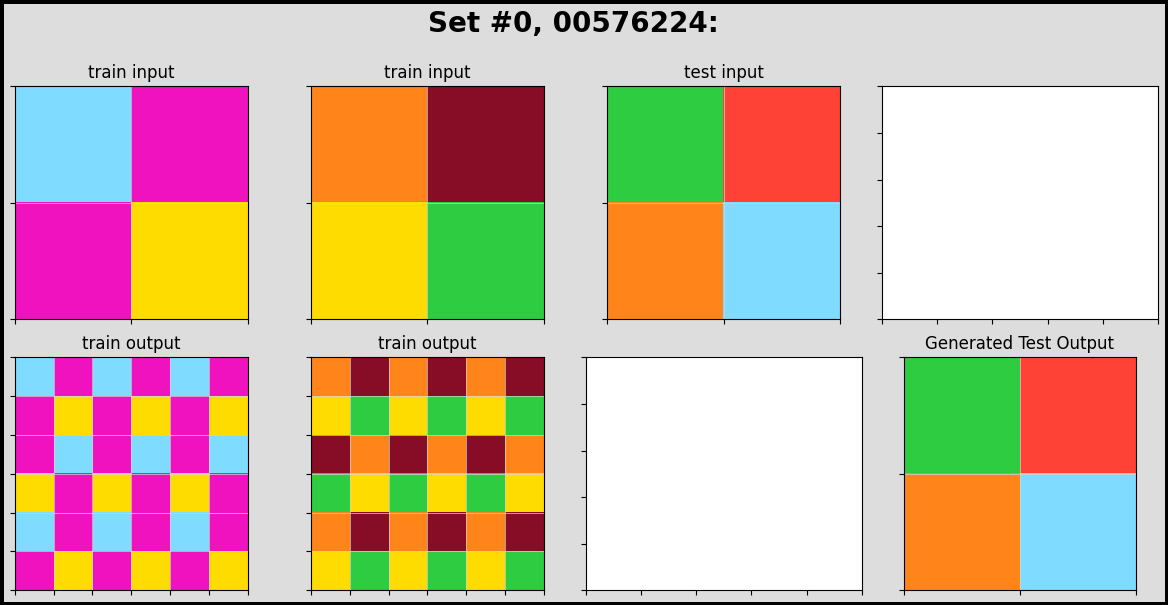



generated_solution [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2], [0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2], [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
#0, 009d5c81


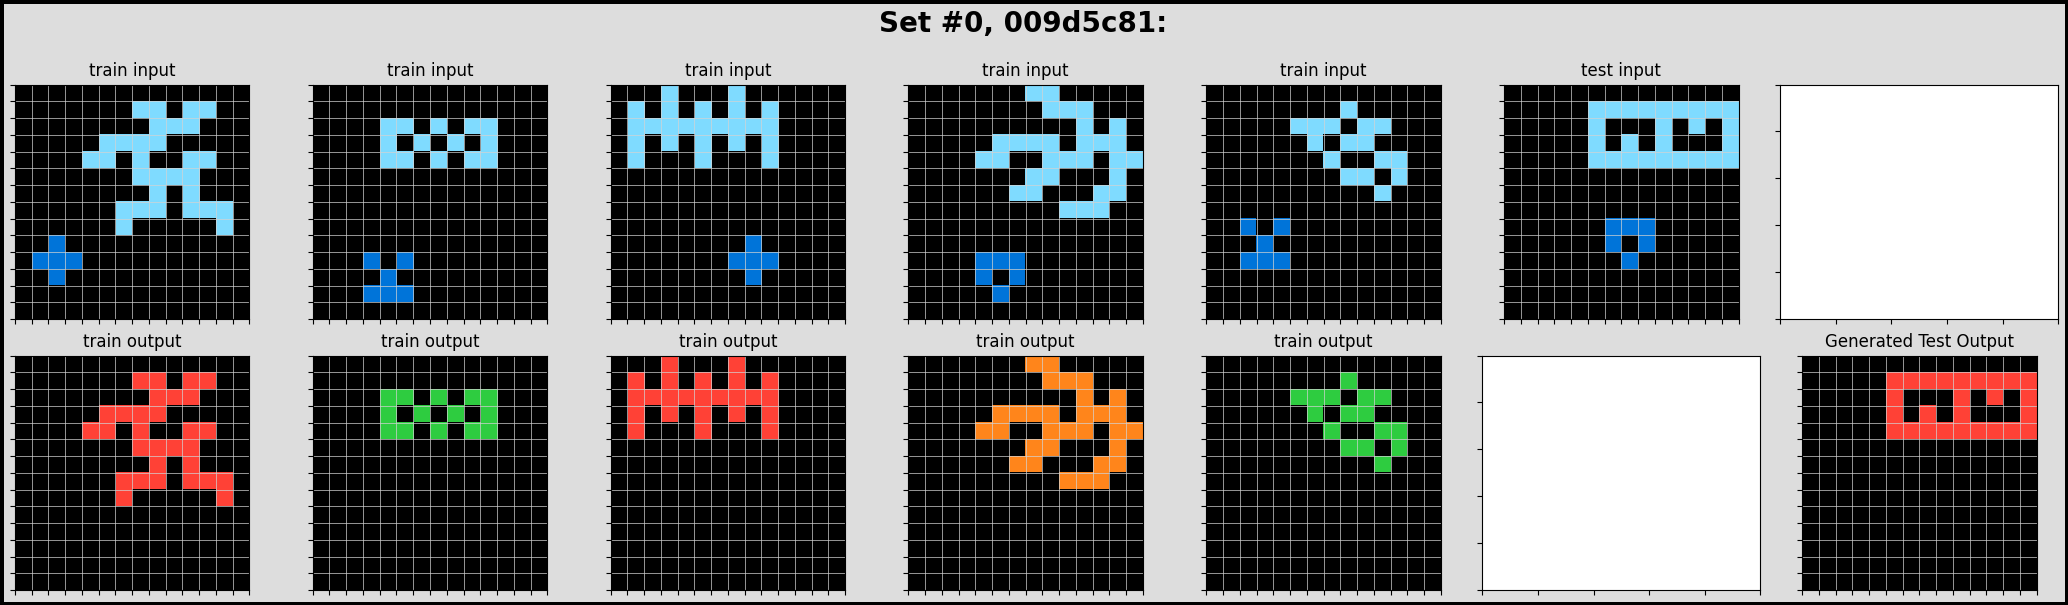



generated_solution [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

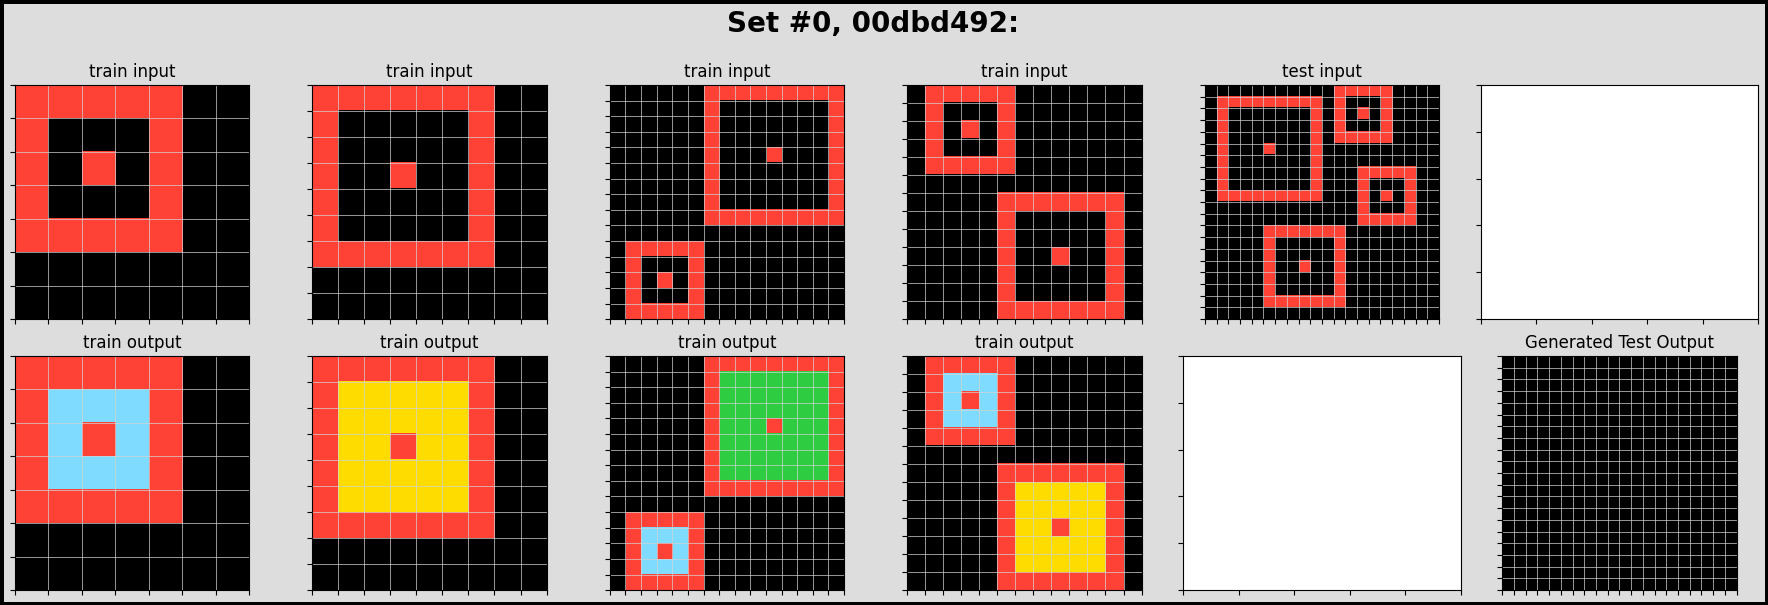



generated_solution [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
#0, 03560426


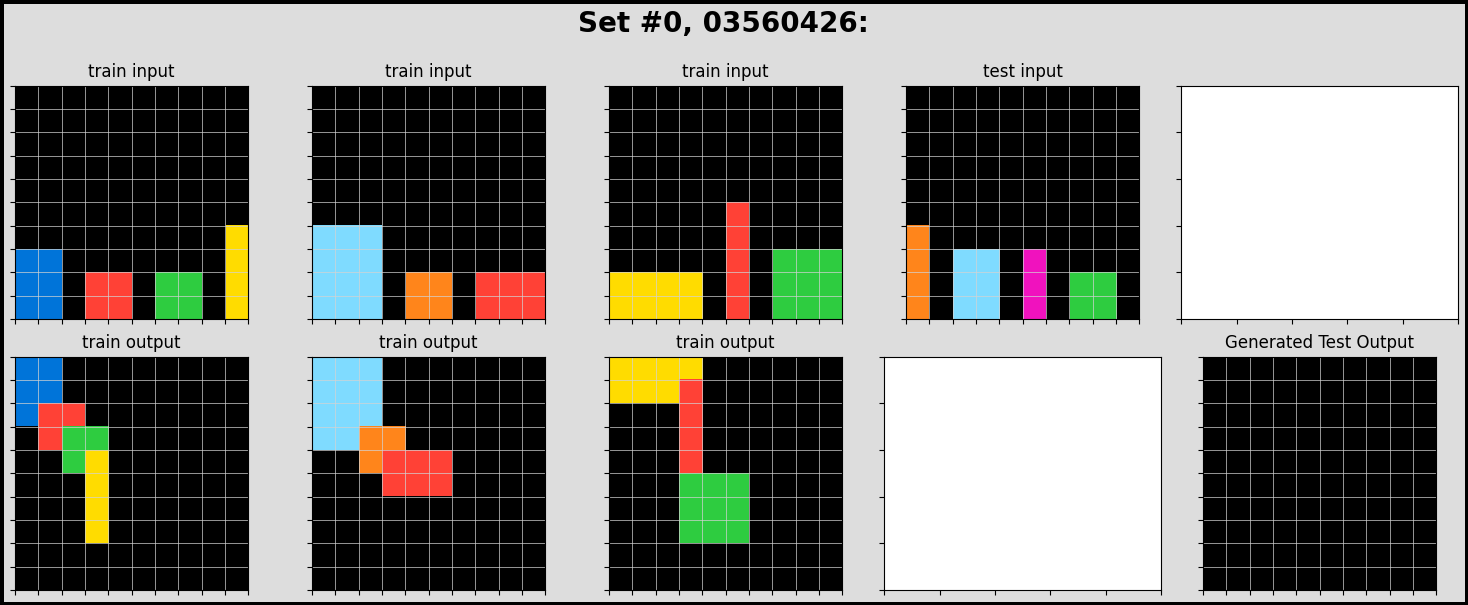



generated_solution [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

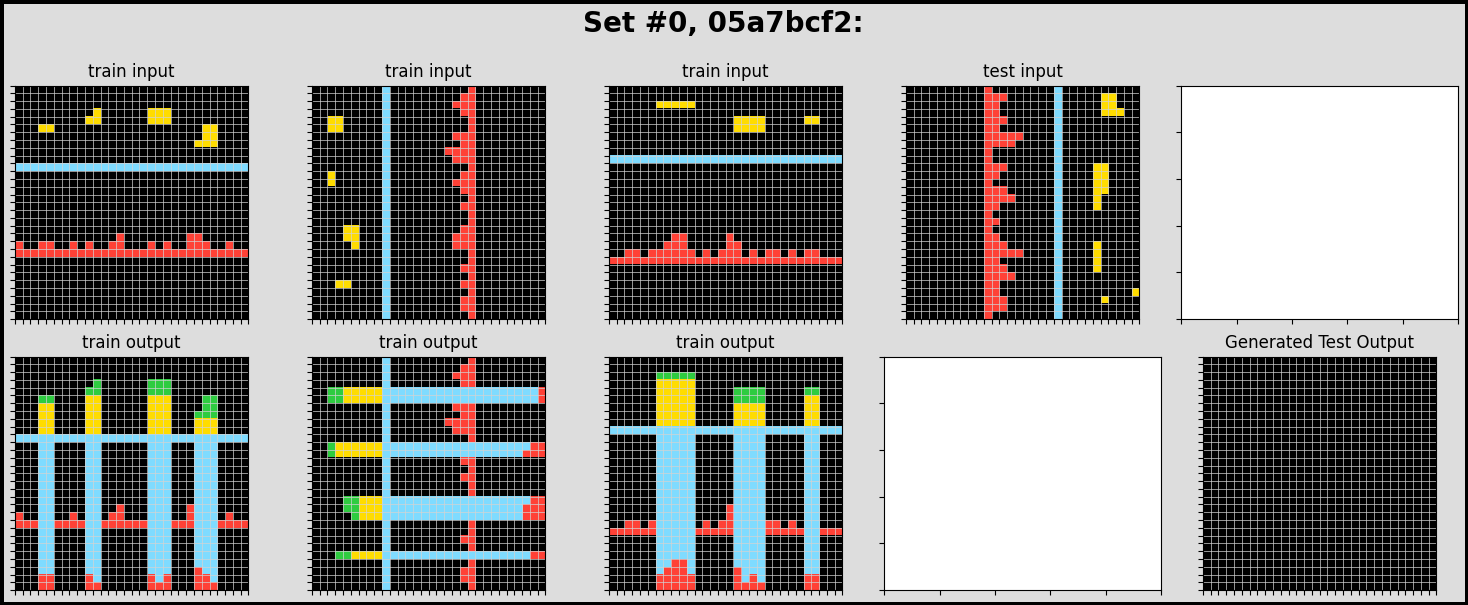



generated_solution [[0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0], [0, 2, 2, 8, 3, 2, 0, 2, 2, 8, 2, 2, 0, 3, 2, 8, 2, 2, 0, 0, 0, 3], [0, 3, 3, 8, 3, 3, 0, 3, 3, 8, 3, 3, 0, 3, 3, 8, 3, 3, 0, 3, 0, 0], [0, 3, 3, 8, 3, 3, 0, 3, 3, 8, 3, 3, 0, 3, 3, 8, 3, 3, 0, 0, 0, 0], [3, 8, 8, 3, 3, 8, 0, 8, 8, 8, 8, 8, 0, 8, 8, 3, 8, 8, 0, 0, 0, 0], [0, 8, 8, 8, 8, 3, 0, 8, 8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0], [0, 2, 3, 8, 2, 2, 0, 2, 2, 3, 2, 3, 0, 2, 2, 8, 2, 2, 0, 0, 0, 3], [0, 3, 3, 8, 3, 3, 0, 3, 3, 8, 3, 3, 0, 3, 3, 8, 3, 3, 0, 3, 0, 0], [0, 3, 3, 8, 3, 3, 0, 3, 3, 8, 3, 3, 0, 3, 3, 8, 3, 3, 0, 0, 0, 0], [0, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 0, 8, 8, 8, 3, 8, 0, 0, 0, 0], [0, 8, 8, 8, 3, 8, 0, 8, 3, 8, 8, 8, 0, 8, 8, 8, 8, 8, 0, 0, 0, 0], [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 3, 0, 0

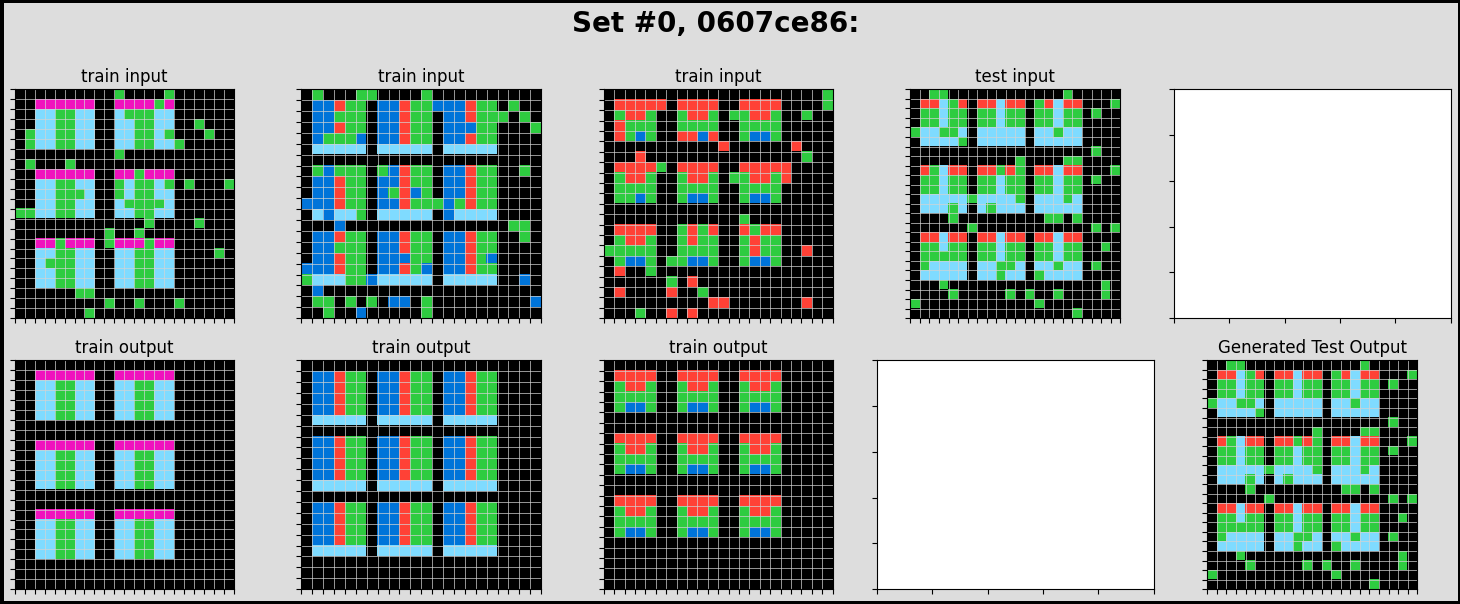



generated_solution [[0, 0, 3], [3, 3, 0], [0, 3, 0]]
#0, 0692e18c


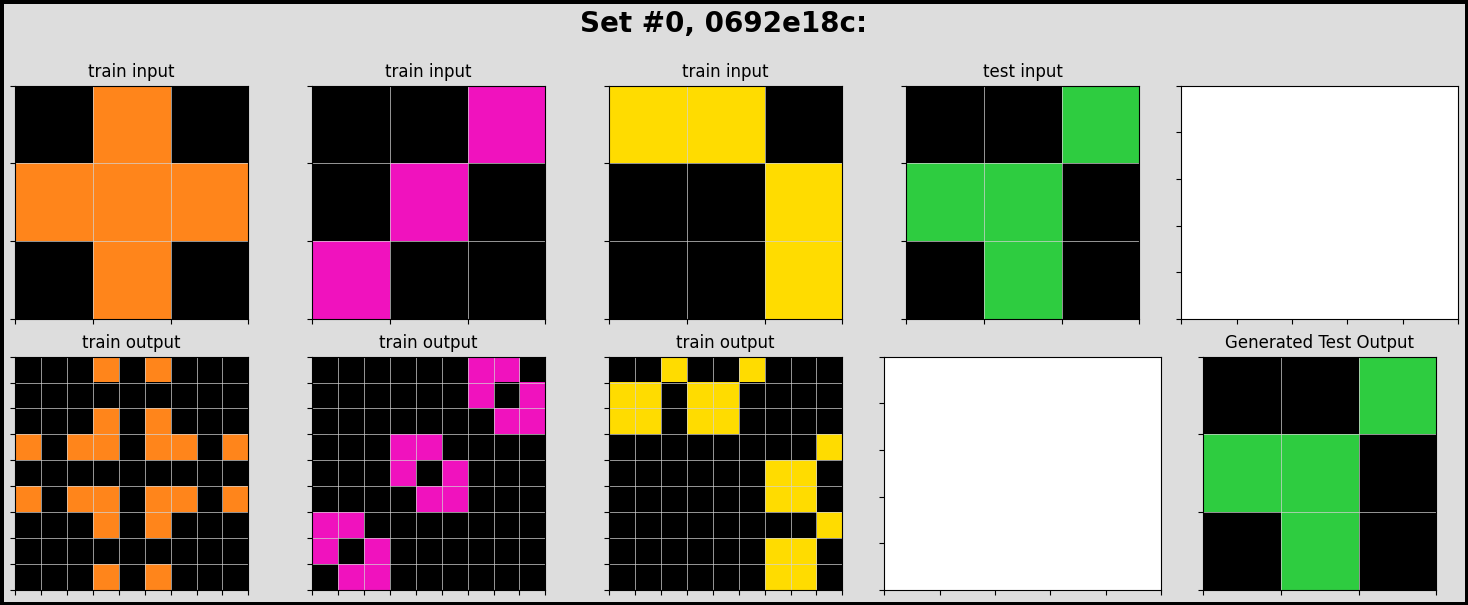



generated_solution [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

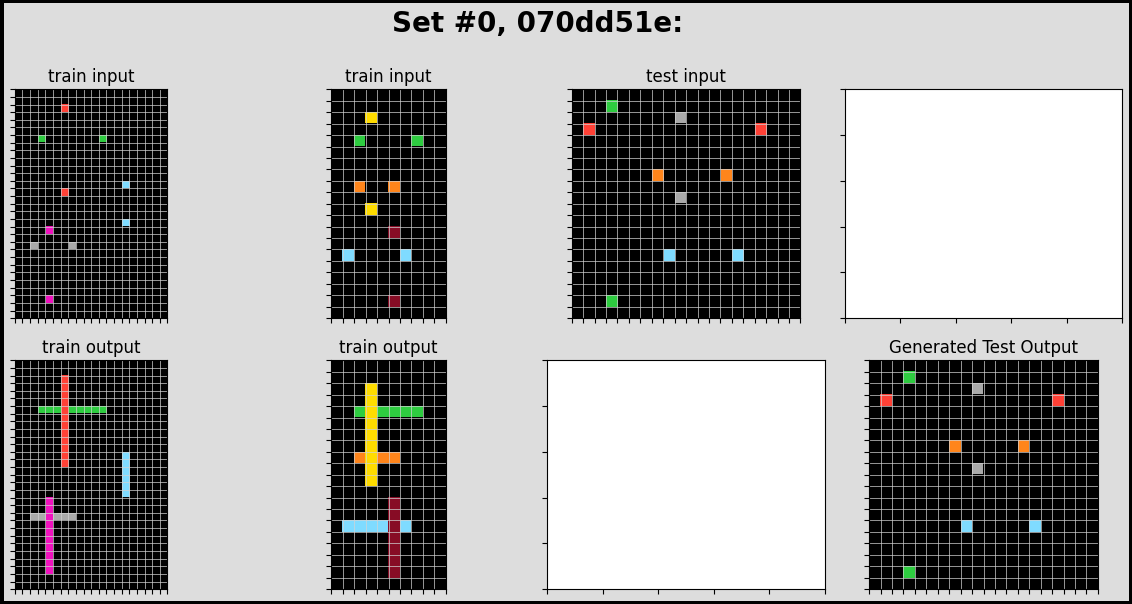



generated_solution [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
#0, 08573cc6


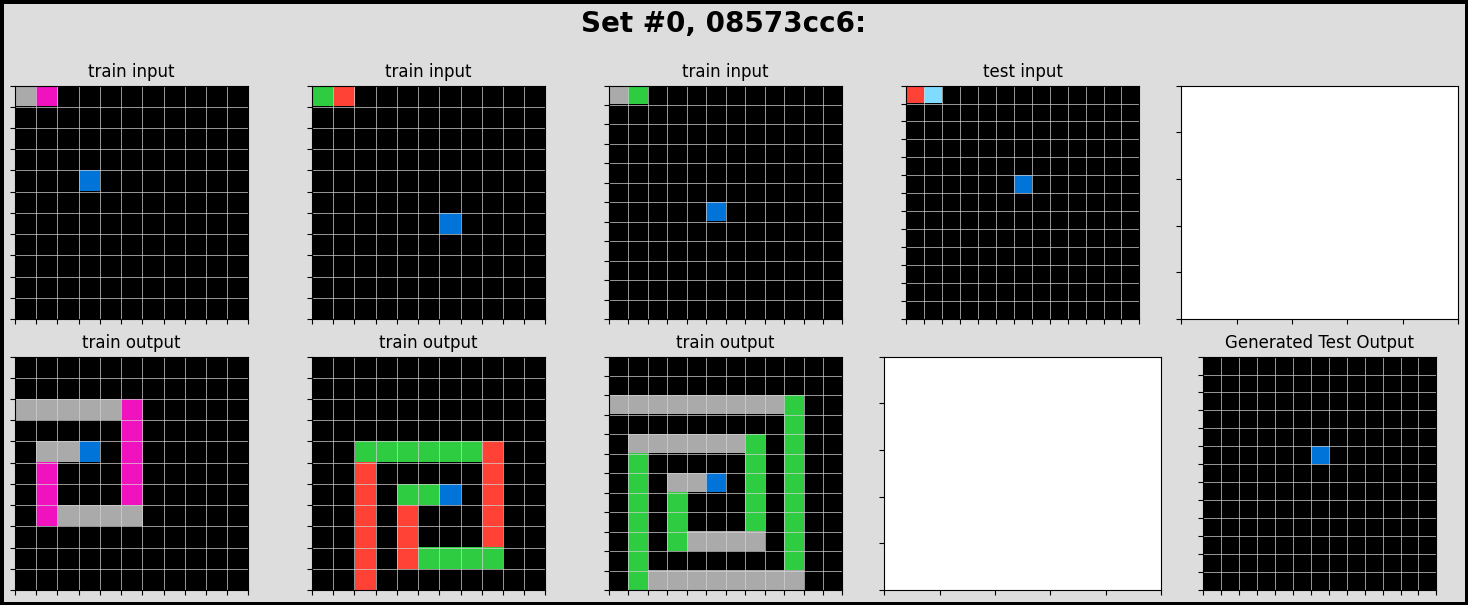



generated_solution [[4, 4, 1, 3, 5, 7, 7, 9, 6, 1, 6, 6, 4, 4, 7, 7, 7, 7, 4, 4, 6, 6, 1, 6, 9, 7, 7, 5, 3, 1], [4, 4, 3, 3, 7, 5, 9, 7, 6, 6, 6, 6, 4, 4, 7, 2, 2, 7, 4, 4, 6, 6, 6, 6, 7, 9, 5, 7, 3, 3], [3, 4, 4, 4, 7, 9, 5, 7, 5, 1, 6, 1, 7, 7, 9, 9, 9, 9, 7, 7, 1, 6, 1, 5, 7, 5, 9, 7, 4, 4], [4, 3, 4, 4, 9, 7, 7, 5, 1, 5, 6, 6, 7, 2, 1, 9, 9, 1, 2, 7, 6, 6, 5, 1, 5, 7, 7, 9, 4, 4], [9, 7, 7, 4, 4, 4, 3, 3, 4, 4, 7, 7, 9, 7, 3, 2, 2, 3, 7, 9, 7, 7, 4, 4, 3, 3, 4, 4, 4, 7], [7, 9, 4, 7, 4, 4, 3, 1, 4, 4, 7, 2, 7, 9, 2, 3, 3, 2, 9, 7, 2, 7, 4, 4, 1, 3, 4, 4, 7, 4], [7, 4, 9, 7, 3, 4, 4, 4, 7, 7, 9, 1, 7, 4, 9, 7, 7, 9, 4, 7, 1, 9, 7, 7, 4, 4, 4, 3, 7, 9], [4, 7, 7, 9, 4, 3, 4, 4, 7, 2, 9, 9, 4, 7, 7, 9, 9, 7, 7, 4, 9, 9, 2, 7, 4, 4, 3, 4, 9, 7], [6, 6, 5, 1, 4, 4, 7, 7, 7, 2, 2, 6, 4, 6, 2, 2, 2, 2, 6, 4, 6, 2, 2, 7, 7, 7, 4, 4, 1, 5], [1, 6, 1, 5, 4, 4, 7, 2, 3, 7, 6, 6, 6, 4, 2, 2, 2, 2, 4, 6, 6, 6, 7, 3, 2, 7, 4, 4, 5, 1], [6, 6, 6, 6, 7, 7, 9, 9, 9, 1, 7, 2, 2, 2, 4, 6, 6, 4, 2, 

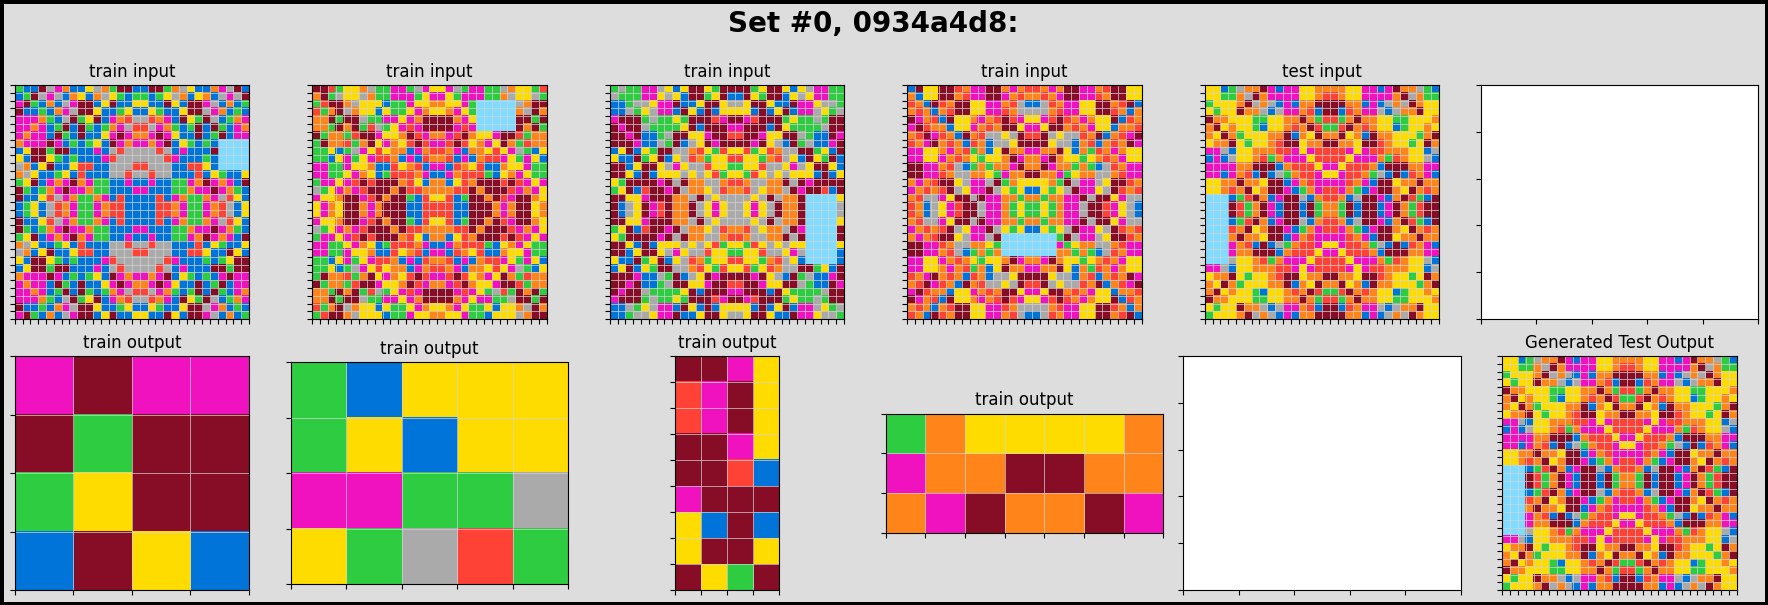

In [16]:
## Number of puzzle cases to visualise
NUM_VISUALISATION_PUZZLES = 10


# DEFINE SET OF DATA TO USE
challenges = test_challenges
solutions = train_solutions
submission_path = 'submission.json'

with open(submission_path, 'r') as sub_file:
        submission = json.load(sub_file)


################### VISUALISE 1 CASE ####################
# task_id = "00576224"
# task = challenges[task_id]
# # task_solution = solutions[task_id][0]
# task_solution = [[0,0]]
# # plot_task(task, task_solution, 0, task_id)

# generated_solution = submission[task_id][0]['attempt_1']  # Assuming you have the generated solution here
# print("generated_solution", generated_solution)
# plot_task(task, task_solution, generated_solution, 0, task_id)


################### VISUALISE MULTIPLE CASES ####################
for i in range(NUM_VISUALISATION_PUZZLES):
    task_id=list(challenges)[i]
    task=challenges[task_id]
    # task_solution = test_solutions[t][0]
    # task_solution = solutions[task_id][0]
    task_solution = [[0,0]]
    generated_solution = submission[task_id][0]['attempt_1']
    print("generated_solution", generated_solution)
    plot_task(task, task_solution, generated_solution, 0, task_id)


# print(test_challenges['05a7bcf2'])